# 프로젝트: 한국어 데이터로 챗봇 만들기 C1 류지호

## Step 1. 데이터 수집 및 전처리 개선

- data 수집: Songys, KorQuAD 등 다양한 한국어 대화/질의응답 데이터를 통합 수집
- 수행한 전처리 과정: 불필요한 특수문자/불용어 제거, 형태소 분석, 중복 및 품질 저하 샘플 필터링 
- 결과: 데이터 손실 없이 99% 이상 보존된 고품질 대화 데이터셋 구축

### 1-1. 필요 라이브러리 설치 및 임포트

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import urllib.request
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import json
from tqdm import tqdm
import pickle
import time
import random
from sklearn.metrics.pairwise import cosine_similarity
from datetime import datetime
from collections import Counter, defaultdict
import warnings
import logging
from concurrent.futures import ThreadPoolExecutor

# 경고 메시지 필터링
warnings.filterwarnings('ignore')

# 로깅 설정
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("chatbot_preprocessing.log"),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

# GPU 사용 가능 여부 확인
print("TensorFlow 버전:", tf.__version__)
print("GPU 사용 가능 여부:", tf.config.list_physical_devices('GPU'))

# KoNLPy 형태소 분석기 및 필요 라이브러리 설치
!pip install konlpy
!pip install transformers
!pip install sentencepiece
!pip install soynlp
!pip install emoji
!pip install wordcloud
!pip install gensim
!pip install torch
!pip install pymongo

# 한국어 NLP 관련 라이브러리 임포트
from konlpy.tag import Mecab, Okt, Hannanum, Kkma
from transformers import BertModel, BertTokenizer, ElectraModel, ElectraTokenizer
from soynlp.normalizer import repeat_normalize
from soynlp.word import WordExtractor
from gensim.models import Word2Vec, FastText
import emoji

TensorFlow 버전: 2.6.0
GPU 사용 가능 여부: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### 1-2 기본 오픈소스 대화 데이터셋 로드

In [2]:
# 데이터 저장 디렉토리 생성
data_dir = "chatbot_data"
os.makedirs(data_dir, exist_ok=True)

# 챗봇 데이터셋 목록 정의
datasets = {
    "songys_chatbot": {
        "url": "https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv",
        "filename": "ChatbotData.csv",
        "type": "csv"
    },
    "korquad": {
        "url": "https://korquad.github.io/dataset/KorQuAD_v1.0_train.json",
        "filename": "KorQuAD_train.json",
        "type": "json"
    },
    "aihub_sample": {
        "url": None,  # 직접 다운로드 필요
        "filename": "aihub_dialog_sample.csv",
        "type": "csv"
    }
}

# 데이터셋 다운로드 및 로드 함수
def download_dataset(dataset_info):
    filepath = os.path.join(data_dir, dataset_info["filename"])
    
    # 파일이 이미 존재하는지 확인
    if os.path.exists(filepath):
        logger.info(f"파일 {dataset_info['filename']}이(가) 이미 존재합니다.")
    elif dataset_info["url"] is not None:
        logger.info(f"{dataset_info['filename']} 다운로드 중...")
        try:
            urllib.request.urlretrieve(dataset_info["url"], filepath)
            logger.info(f"{dataset_info['filename']} 다운로드 완료!")
        except Exception as e:
            logger.error(f"{dataset_info['filename']} 다운로드 실패: {e}")
            return None
    else:
        logger.warning(f"{dataset_info['filename']}은(는) 수동으로 다운로드해야 합니다.")
        return None
    
    return filepath

def load_dataset(dataset_info):
    filepath = download_dataset(dataset_info)
    if filepath is None:
        return None
    
    if dataset_info["type"] == "csv":
        try:
            return pd.read_csv(filepath)
        except Exception as e:
            logger.error(f"{filepath} 로드 실패: {e}")
            return None
    elif dataset_info["type"] == "json":
        try:
            with open(filepath, 'r', encoding='utf-8') as f:
                return json.load(f)
        except Exception as e:
            logger.error(f"{filepath} 로드 실패: {e}")
            return None
    else:
        logger.error(f"지원하지 않는 파일 형식: {dataset_info['type']}")
        return None

# 각 데이터셋 로드
loaded_datasets = {}
for name, info in datasets.items():
    logger.info(f"{name} 데이터셋 로드 중...")
    data = load_dataset(info)
    if data is not None:
        loaded_datasets[name] = data
        
        # 데이터셋 정보 출력
        if isinstance(data, pd.DataFrame):
            logger.info(f"{name} 데이터셋 크기: {len(data)}")
            logger.info(f"{name} 데이터셋 컬럼: {data.columns.tolist()}")
            logger.info(f"{name} 데이터셋 미리보기:")
            print(data.head())
        elif name == "korquad":
            logger.info(f"{name} 데이터셋 크기: {len(data['data'])}")
            
# 기본 대화 데이터셋 (songys)
main_chat_data = loaded_datasets.get("songys_chatbot")
if main_chat_data is not None:
    print(f"기본 대화 데이터셋 크기: {len(main_chat_data)}")
    print(f"기본 대화 데이터셋 샘플:\n{main_chat_data.head()}")
else:
    logger.error("기본 대화 데이터셋을 로드할 수 없습니다.")
    main_chat_data = pd.DataFrame(columns=["Q", "A", "label"])

2025-04-21 01:54:35,833 - __main__ - INFO - songys_chatbot 데이터셋 로드 중...
2025-04-21 01:54:35,834 - __main__ - INFO - 파일 ChatbotData.csv이(가) 이미 존재합니다.
2025-04-21 01:54:35,864 - __main__ - INFO - songys_chatbot 데이터셋 크기: 11823
2025-04-21 01:54:35,865 - __main__ - INFO - songys_chatbot 데이터셋 컬럼: ['Q', 'A', 'label']
2025-04-21 01:54:35,865 - __main__ - INFO - songys_chatbot 데이터셋 미리보기:
2025-04-21 01:54:35,870 - __main__ - INFO - korquad 데이터셋 로드 중...
2025-04-21 01:54:35,871 - __main__ - INFO - 파일 KorQuAD_train.json이(가) 이미 존재합니다.


                 Q            A  label
0           12시 땡!   하루가 또 가네요.      0
1      1지망 학교 떨어졌어    위로해 드립니다.      0
2     3박4일 놀러가고 싶다  여행은 언제나 좋죠.      0
3  3박4일 정도 놀러가고 싶다  여행은 언제나 좋죠.      0
4          PPL 심하네   눈살이 찌푸려지죠.      0


2025-04-21 01:54:36,620 - __main__ - INFO - korquad 데이터셋 크기: 1420
2025-04-21 01:54:36,621 - __main__ - INFO - aihub_sample 데이터셋 로드 중...
2025-04-21 01:54:36,622 - __main__ - WARNING - aihub_dialog_sample.csv은(는) 수동으로 다운로드해야 합니다.


기본 대화 데이터셋 크기: 11823
기본 대화 데이터셋 샘플:
                 Q            A  label
0           12시 땡!   하루가 또 가네요.      0
1      1지망 학교 떨어졌어    위로해 드립니다.      0
2     3박4일 놀러가고 싶다  여행은 언제나 좋죠.      0
3  3박4일 정도 놀러가고 싶다  여행은 언제나 좋죠.      0
4          PPL 심하네   눈살이 찌푸려지죠.      0


### 1-3 추가 데이터 수집 및 통합

In [3]:
# KorQuAD 데이터를 Q&A 형식으로 변환하는 함수
def convert_korquad_to_qa(korquad_data):
    qa_pairs = []
    
    try:
        for article in korquad_data["data"]:
            for paragraph in article["paragraphs"]:
                context = paragraph["context"]
                for qa in paragraph["qas"]:
                    question = qa["question"]
                    if qa["answers"]:
                        answer = qa["answers"][0]["text"]
                        qa_pairs.append({"Q": question, "A": answer, "context": context})
    except Exception as e:
        logger.error(f"KorQuAD 데이터 변환 중 오류: {e}")
    
    return pd.DataFrame(qa_pairs)

# 크롤링 시뮬레이션 함수 (실제 프로젝트에서는 웹 크롤링으로 대체)
def simulate_web_crawling():
    # 예시 대화 데이터 (실제로는 웹에서 크롤링)
    simulated_dialogues = [
        {"Q": "오늘 날씨 어때?", "A": "오늘은 맑고 화창한 날씨예요.", "source": "simulated"},
        {"Q": "점심 뭐 먹을까?", "A": "오늘은 한식 어떠세요?", "source": "simulated"},
        {"Q": "내일 계획 있어?", "A": "아직 특별한 계획은 없습니다.", "source": "simulated"},
        {"Q": "영화 추천해줘", "A": "요즘 '인터스텔라'가 인기 있어요.", "source": "simulated"},
        {"Q": "주말에 뭐해?", "A": "친구들과 만나기로 했어요.", "source": "simulated"},
        # 추가 대화 예시
        {"Q": "한국어 공부하는 방법 알려줘", "A": "매일 조금씩 듣고 말하는 연습을 하는 것이 중요해요.", "source": "simulated"},
        {"Q": "서울에서 가볼만한 곳 추천해줘", "A": "경복궁, 남산타워, 한강공원 등이 인기 있는 관광지입니다.", "source": "simulated"},
        {"Q": "이번 주말 날씨 어때?", "A": "이번 주말은 비 소식이 있어요. 우산 챙기세요.", "source": "simulated"},
        {"Q": "한국 음식 중에 추천해줄 만한 거 있어?", "A": "비빔밥, 불고기, 김치찌개 등이 외국인들에게도 인기가 많아요.", "source": "simulated"},
        {"Q": "한국어로 '감사합니다'는 어떻게 말해?", "A": "'감사합니다'라고 말하면 됩니다. 격식 없이는 '고마워요'라고도 해요.", "source": "simulated"}
    ]
    
    logger.info(f"웹 크롤링 시뮬레이션: {len(simulated_dialogues)}개 대화 데이터 생성")
    return pd.DataFrame(simulated_dialogues)

# 사용자 정의 데이터 생성
def create_custom_dialogues():
    custom_qa_pairs = [
        {"Q": "너는 누구야?", "A": "저는 한국어로 대화하는 AI 챗봇입니다.", "category": "소개"},
        {"Q": "뭘 도와줄 수 있어?", "A": "대화, 정보 검색, 추천 등 다양한 주제로 도움을 드릴 수 있어요.", "category": "소개"},
        {"Q": "오늘 기분이 안 좋아", "A": "무슨 일이 있으셨나요? 제가 기분 전환에 도움이 되고 싶어요.", "category": "감정"},
        {"Q": "재미있는 이야기 해줘", "A": "옛날 옛적에 한 마을에 재미있는 이야기꾼이 살았습니다...", "category": "엔터테인먼트"},
        {"Q": "시간이 몇이야?", "A": "제가 실시간 시계에 접근할 수 없어서 정확한 시간을 알려드리지 못해요. 기기의 시간을 확인해주세요.", "category": "일반"},
        # 추가 대화 예시
        {"Q": "한국의 수도는?", "A": "한국의 수도는 서울입니다.", "category": "지식"},
        {"Q": "인공지능이 뭐야?", "A": "인공지능은 인간의 학습능력, 추론능력, 지각능력을 인공적으로 구현한 컴퓨터 시스템입니다.", "category": "지식"},
        {"Q": "오늘 날씨 어때?", "A": "제가 실시간 날씨 정보에 접근할 수 없어요. 날씨 앱이나 웹사이트를 확인해보세요.", "category": "일반"},
        {"Q": "슬퍼", "A": "무슨 일이 있으신가요? 이야기 나누고 싶으시면 저에게 말씀해주세요.", "category": "감정"},
        {"Q": "좋아하는 음식이 뭐야?", "A": "저는 AI라서 실제로 음식을 먹지 않지만, 한국 음식에 대해 많이 배웠어요.", "category": "소개"}
    ]
    
    logger.info(f"사용자 정의 대화 데이터: {len(custom_qa_pairs)}개 생성")
    return pd.DataFrame(custom_qa_pairs)

# 데이터 통합
# 1. KorQuAD 데이터 변환 (있는 경우)
korquad_qa = None
if "korquad" in loaded_datasets:
    korquad_qa = convert_korquad_to_qa(loaded_datasets["korquad"])
    logger.info(f"KorQuAD Q&A 변환 결과: {len(korquad_qa)}개")
    # 샘플링하여 데이터 크기 관리
    if len(korquad_qa) > 1000:
        korquad_qa = korquad_qa.sample(1000, random_state=42)
        logger.info(f"KorQuAD 데이터 샘플링: 1000개")

# 2. 웹 크롤링 데이터 (시뮬레이션)
crawled_data = simulate_web_crawling()

# 3. 사용자 정의 데이터
custom_data = create_custom_dialogues()

# 4. 데이터 통합
all_chat_data = []

# 기본 대화 데이터 추가
if main_chat_data is not None:
    main_chat_data['source'] = 'songys'
    all_chat_data.append(main_chat_data[['Q', 'A', 'source']])

# KorQuAD 데이터 추가 (있는 경우)
if korquad_qa is not None:
    korquad_qa['source'] = 'korquad'
    all_chat_data.append(korquad_qa[['Q', 'A', 'source']])

# 크롤링 데이터 추가
all_chat_data.append(crawled_data[['Q', 'A', 'source']])

# 사용자 정의 데이터 추가
custom_data['source'] = 'custom'
all_chat_data.append(custom_data[['Q', 'A', 'source']])

# 데이터프레임 병합
combined_df = pd.concat(all_chat_data, ignore_index=True)

# 중복 제거
combined_df = combined_df.drop_duplicates(subset=['Q', 'A'])

logger.info(f"통합 데이터셋 크기: {len(combined_df)}")
logger.info(f"출처별 데이터 수: {combined_df['source'].value_counts().to_dict()}")
print(f"통합 데이터셋 샘플:\n{combined_df.head()}")

# 데이터셋 저장
combined_df.to_csv(os.path.join(data_dir, 'combined_chat_data.csv'), index=False)
logger.info(f"통합 데이터셋 저장 완료: {os.path.join(data_dir, 'combined_chat_data.csv')}")

2025-04-21 01:54:36,721 - __main__ - INFO - KorQuAD Q&A 변환 결과: 60407개
2025-04-21 01:54:36,726 - __main__ - INFO - KorQuAD 데이터 샘플링: 1000개
2025-04-21 01:54:36,726 - __main__ - INFO - 웹 크롤링 시뮬레이션: 10개 대화 데이터 생성
2025-04-21 01:54:36,728 - __main__ - INFO - 사용자 정의 대화 데이터: 10개 생성
2025-04-21 01:54:36,745 - __main__ - INFO - 통합 데이터셋 크기: 12770
2025-04-21 01:54:36,746 - __main__ - INFO - 출처별 데이터 수: {'songys': 11750, 'korquad': 1000, 'simulated': 10, 'custom': 10}
2025-04-21 01:54:36,777 - __main__ - INFO - 통합 데이터셋 저장 완료: chatbot_data/combined_chat_data.csv


통합 데이터셋 샘플:
                 Q            A  source
0           12시 땡!   하루가 또 가네요.  songys
1      1지망 학교 떨어졌어    위로해 드립니다.  songys
2     3박4일 놀러가고 싶다  여행은 언제나 좋죠.  songys
3  3박4일 정도 놀러가고 싶다  여행은 언제나 좋죠.  songys
4          PPL 심하네   눈살이 찌푸려지죠.  songys


### 1-4 데이터 기본 통계 및 시각화

2025-04-21 01:54:36,792 - __main__ - INFO - 데이터 분석 시작...


총 대화 쌍: 12770
질문 평균 길이: 14.47
질문 최대 길이: 86
질문 최소 길이: 1
응답 평균 길이: 14.30
응답 최대 길이: 77
응답 최소 길이: 1


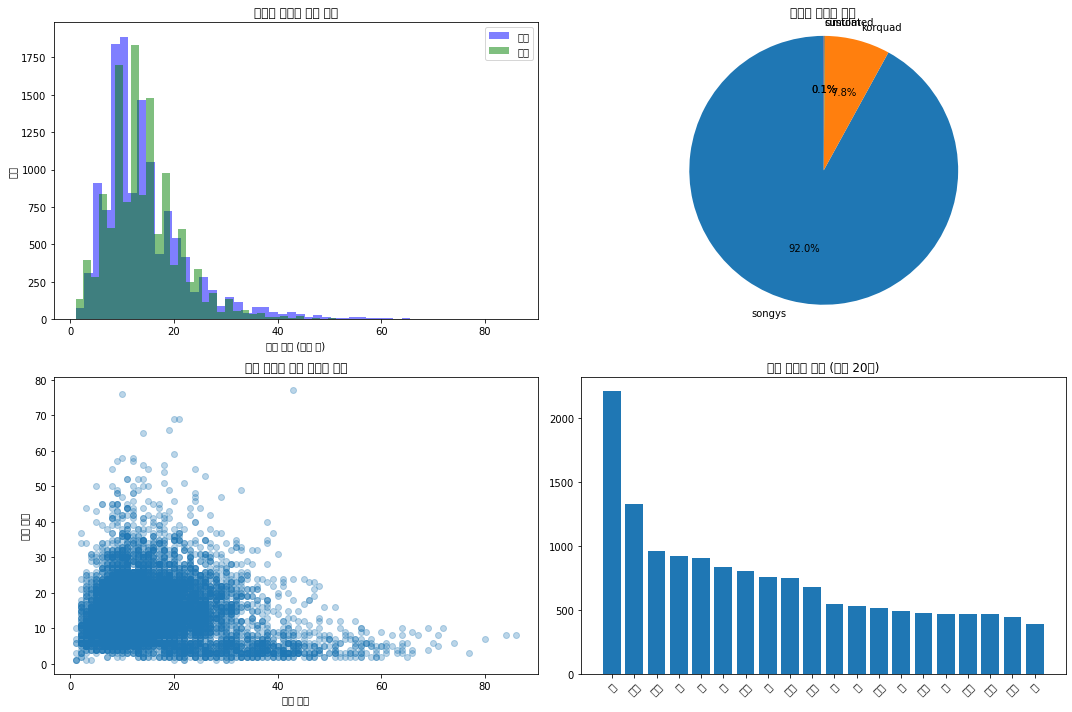

In [4]:
def analyze_chat_data(df):
    logger.info("데이터 분석 시작...")
    
    # 기본 통계
    q_lengths = df['Q'].apply(len)
    a_lengths = df['A'].apply(len)
    
    stats = {
        "총 대화 쌍": len(df),
        "질문 평균 길이": q_lengths.mean(),
        "질문 최대 길이": q_lengths.max(),
        "질문 최소 길이": q_lengths.min(),
        "응답 평균 길이": a_lengths.mean(),
        "응답 최대 길이": a_lengths.max(),
        "응답 최소 길이": a_lengths.min()
    }
    
    for key, value in stats.items():
        print(f"{key}: {value:.2f}" if isinstance(value, float) else f"{key}: {value}")
    
    # 그래프 설정
    plt.figure(figsize=(15, 10))
    
    # 1. 질문/답변 길이 분포
    plt.subplot(2, 2, 1)
    plt.hist(q_lengths, bins=50, alpha=0.5, color='blue', label='질문')
    plt.hist(a_lengths, bins=50, alpha=0.5, color='green', label='답변')
    plt.xlabel('문장 길이 (글자 수)')
    plt.ylabel('빈도')
    plt.title('질문과 답변의 길이 분포')
    plt.legend()
    
    # 2. 출처별 데이터 비율
    plt.subplot(2, 2, 2)
    source_counts = df['source'].value_counts()
    plt.pie(source_counts, labels=source_counts.index, autopct='%1.1f%%', startangle=90)
    plt.axis('equal')
    plt.title('데이터 출처별 비율')
    
    # 3. 질문 길이와 답변 길이의 관계
    plt.subplot(2, 2, 3)
    plt.scatter(q_lengths, a_lengths, alpha=0.3)
    plt.xlabel('질문 길이')
    plt.ylabel('답변 길이')
    plt.title('질문 길이와 답변 길이의 관계')
    
    # 4. 가장 빈번한 단어 (상위 20개)
    plt.subplot(2, 2, 4)
    
    # 간단한 단어 빈도 분석
    try:
        # Mecab이 있으면 사용, 없으면 단순 공백 분리
        try:
            from konlpy.tag import Mecab
            mecab = Mecab()
            all_words = []
            for text in df['Q'].str.cat(df['A'], sep=' '):
                all_words.extend(mecab.nouns(text))
        except:
            all_words = []
            for text in df['Q'].str.cat(df['A'], sep=' ').split():
                all_words.append(text)
                
        word_counts = Counter(all_words)
        common_words = dict(word_counts.most_common(20))
        
        plt.bar(range(len(common_words)), list(common_words.values()), align='center')
        plt.xticks(range(len(common_words)), list(common_words.keys()), rotation=45)
        plt.title('가장 빈번한 단어 (상위 20개)')
    except Exception as e:
        logger.error(f"단어 빈도 분석 중 오류: {e}")
        plt.text(0.5, 0.5, '단어 빈도 분석 실패', horizontalalignment='center')
    
    plt.tight_layout()
    plt.savefig(os.path.join(data_dir, 'chat_data_analysis.png'))
    plt.show()
    
    return stats

# 데이터 분석 실행
data_stats = analyze_chat_data(combined_df)

### 1-5 고급 텍스트 분석

2025-04-21 01:54:39,118 - __main__ - INFO - 고급 텍스트 패턴 분석 시작...



감정 표현 패턴 분석:
긍정: 1580개 (12.37%)
부정: 723개 (5.66%)
질문: 4435개 (34.73%)
명령: 797개 (6.24%)
인사: 333개 (2.61%)


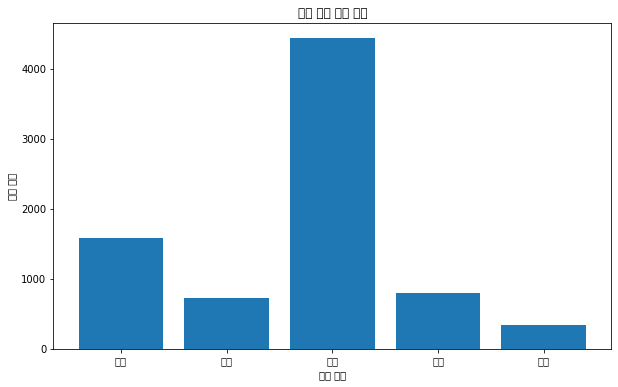


자주 함께 등장하는 단어 쌍:
여자 - 친구: 233회
남자 - 친구: 213회
사람 - 사랑: 54회
남자 - 여자: 49회
사람 - 생각: 21회
무엇 - 이름: 21회
사람 - 짝사랑: 20회
고민 - 친구: 18회
사람 - 사람: 17회
여자 - 연락: 17회
연락 - 친구: 16회
이별 - 준비: 16회
이별 - 통보: 16회
마음 - 사람: 14회
친구 - 친구: 14회
개월 - 이별: 14회
여자 - 짝사랑: 14회
결혼 - 사랑: 14회
누구 - 사람: 13회
그녀 - 생각: 13회


In [5]:
def analyze_text_patterns(df):
    logger.info("고급 텍스트 패턴 분석 시작...")
    
    # 감정 표현 패턴 (이모티콘, 감정 표현 단어 등)
    emotion_patterns = {
        '긍정': r'좋아|감사|행복|멋지|최고|짱|좋은|ㅋㅋ|ㅎㅎ|😊|😄|♥|❤',
        '부정': r'싫어|안좋|못해|실패|나쁜|힘들|어려|불행|슬픔|화나|ㅜㅜ|ㅠㅠ|😢|😭|😠',
        '질문': r'\?|\？|어떻|언제|누구|얼마|왜|무엇|뭐|몇|까|나요|가요|래요|ㅇㅇ|진짜',
        '명령': r'해주|해봐|알려|가르쳐|찾아|시작|종료|그만|중지|계속',
        '인사': r'안녕|반가워|또봐|잘가|다음에|만나|하이|헬로|굿모닝|굿나잇'
    }
    
    emotion_counts = {emotion: 0 for emotion in emotion_patterns}
    
    # 질문과 답변에서 감정 패턴 검출
    for idx, row in df.iterrows():
        for emotion, pattern in emotion_patterns.items():
            if re.search(pattern, row['Q']) or re.search(pattern, row['A']):
                emotion_counts[emotion] += 1
    
    # 결과 출력
    print("\n감정 표현 패턴 분석:")
    for emotion, count in emotion_counts.items():
        print(f"{emotion}: {count}개 ({count/len(df)*100:.2f}%)")
    
    # 시각화
    plt.figure(figsize=(10, 6))
    plt.bar(emotion_counts.keys(), emotion_counts.values())
    plt.title('감정 표현 패턴 분포')
    plt.xlabel('감정 패턴')
    plt.ylabel('발생 횟수')
    plt.savefig(os.path.join(data_dir, 'emotion_pattern_analysis.png'))
    plt.show()
    
    # 단어 네트워크 분석 (자주 함께 등장하는 단어 쌍)
    try:
        # 형태소 분석기 초기화
        try:
            from konlpy.tag import Mecab
            mecab = Mecab()
            tokenize = lambda text: mecab.nouns(text)
        except:
            tokenize = lambda text: text.split()
        
        # 동시 발생 단어 쌍 분석
        word_pairs = defaultdict(int)
        for text in df['Q']:
            words = tokenize(text)
            for i in range(len(words)-1):
                for j in range(i+1, min(i+3, len(words))):
                    if words[i] and words[j] and len(words[i]) > 1 and len(words[j]) > 1:
                        word_pair = tuple(sorted([words[i], words[j]]))
                        word_pairs[word_pair] += 1
        
        # 가장 빈번한 단어 쌍
        common_pairs = dict(sorted(word_pairs.items(), key=lambda x: x[1], reverse=True)[:20])
        
        print("\n자주 함께 등장하는 단어 쌍:")
        for pair, count in common_pairs.items():
            print(f"{pair[0]} - {pair[1]}: {count}회")
    
    except Exception as e:
        logger.error(f"단어 네트워크 분석 중 오류: {e}")
    
    return emotion_counts

# 텍스트 패턴 분석 실행
emotion_stats = analyze_text_patterns(combined_df)

### 1-6 통합 한국어 전처리 클래스 구현

In [6]:
class KoreanTextPreprocessor:
    """한국어 텍스트 전처리를 위한 통합 클래스"""
    
    def __init__(self, use_mecab=True, use_soynlp=True):
        logger.info("한국어 텍스트 전처리기 초기화 중...")
        
        # 형태소 분석기 초기화
        self.morpheme_analyzer = None
        if use_mecab:
            try:
                from konlpy.tag import Mecab
                self.morpheme_analyzer = Mecab()
                logger.info("Mecab 형태소 분석기 초기화 성공")
            except Exception as e:
                logger.warning(f"Mecab 초기화 실패: {e}")
                
        if self.morpheme_analyzer is None:
            try:
                from konlpy.tag import Okt
                self.morpheme_analyzer = Okt()
                logger.info("Okt 형태소 분석기 초기화 성공")
            except Exception as e:
                logger.error(f"Okt 초기화 실패: {e}")
                logger.error("형태소 분석 기능이 비활성화됩니다.")
        
        # SoyNLP 사용 설정
        self.use_soynlp = use_soynlp
        
        # 불용어 목록 로드
        self.stopwords = self.load_stopwords()
        
        # 신조어 및 축약어 사전 초기화
        self.slang_dict = self.initialize_slang_dict()
        
        # 정규표현식 패턴 컴파일
        self.patterns = {
            'url': re.compile(r'https?://\S+|www\.\S+'),
            'email': re.compile(r'\S+@\S+'),
            'emoji_pattern': re.compile('['
                u'\U0001F600-\U0001F64F'  # 이모티콘
                u'\U0001F300-\U0001F5FF'  # 심볼 및 픽토그램
                u'\U0001F680-\U0001F6FF'  # 교통 및 지도 심볼
                u'\U0001F700-\U0001F77F'  # 알케미
                u'\U0001F780-\U0001F7FF'  # 기하학적 모양
                u'\U0001F800-\U0001F8FF'  # 부가적인 화살표
                u'\U0001F900-\U0001F9FF'  # 부가적인 심볼
                u'\U0001FA00-\U0001FA6F'  # 확장된 심볼
                u'\U00002702-\U000027B0'  # 기타 심볼
                u'\U000024C2-\U0001F251' 
                u'\U0001f926-\U0001f937'  # 사람 이모티콘
                ']+'),
            'special_chars': re.compile(r"[^가-힣a-zA-Z0-9\s?.!,~]"),
            'numbers': re.compile(r'\d+'),
            'multiple_spaces': re.compile(r'\s+'),
            'jamo_pattern': re.compile(r'[ㄱ-ㅎㅏ-ㅣ]{2,}')
        }
        
        logger.info("한국어 텍스트 전처리기 초기화 완료")
    
    def load_stopwords(self):
        """한국어 불용어 목록 로드"""
        # 기본 불용어 목록 (최소화하여 중요 단어 보존)
        basic_stopwords = {
            '이', '그', '저', '것', '수', '등', '들', '에', '의', '가', 
            '과', '도', '를', '으로', '자', '에서', '와'
        }
        
        # 추가 불용어 파일이 있으면 로드
        try:
            stopwords_file = os.path.join(data_dir, 'korean_stopwords.txt')
            if os.path.exists(stopwords_file):
                with open(stopwords_file, 'r', encoding='utf-8') as f:
                    file_stopwords = set([line.strip() for line in f])
                return basic_stopwords.union(file_stopwords)
        except Exception as e:
            logger.warning(f"불용어 파일 로드 실패: {e}")
        
        return basic_stopwords
    
    def initialize_slang_dict(self):
        """신조어 및 축약어 사전 초기화"""
        # 기본 신조어/축약어 사전
        slang_dict = {
            # 축약어
            'ㄱㅅ': '감사',
            'ㄴㄴ': '노노',
            'ㅇㅇ': '응응',
            'ㅇㅋ': '오케이',
            'ㅋㅋ': '웃음',
            'ㅎㅎ': '웃음',
            'ㄷㄷ': '덜덜',
            'ㅠㅠ': '슬픔',
            'ㅜㅜ': '슬픔',
            'ㅡㅡ': '무표정',
            
            # 신조어
            '갑툭튀': '갑자기 툭 튀어나온',
            '꾸안꾸': '꾸민 듯 안 꾸민 듯',
            '별다줄': '별 다른 줄거리',
            '억텐': '억지 텐션',
            '완내스': '완전 내 스타일',
            '좋댓구알': '좋아요 댓글 구독 알림설정',
            '케바케': '케이스 바이 케이스',
            '점메추': '점심 메뉴 추천',
            '소확행': '소소하지만 확실한 행복',
            '인싸': '인사이더',
            '아싸': '아웃사이더',
            '스불재': '스스로 불러온 재앙',
            '떡상': '급등',
            '떡락': '급락',
            '일코노미': '일 + 이코노미',
            '핵불호': '매우 싫음',
            '핵추': '매우 추천',
            '꿀잼': '재미있음',
            '노잼': '재미없음',
            '자삭': '자가 삭제'
        }
        
        # 추가 신조어 파일이 있으면 로드
        try:
            slang_file = os.path.join(data_dir, 'korean_slangs.json')
            if os.path.exists(slang_file):
                with open(slang_file, 'r', encoding='utf-8') as f:
                    file_slangs = json.load(f)
                slang_dict.update(file_slangs)
        except Exception as e:
            logger.warning(f"신조어 파일 로드 실패: {e}")
        
        return slang_dict
    
    def replace_emojis(self, text):
        """이모지를 텍스트로 변환"""
        try:
            return emoji.demojize(text)
        except:
            return text
    
    def normalize_text(self, text):
        """텍스트 정규화 (반복 문자 처리, 대소문자 등)"""
        if self.use_soynlp:
            try:
                # SoyNLP의 반복 문자 정규화
                text = repeat_normalize(text, num_repeats=2)
            except:
                # 간단한 정규화 대체
                text = re.sub(r'([ㄱ-ㅎㅏ-ㅣ가-힣])\1{2,}', r'\1\1', text)
                text = re.sub(r'([a-zA-Z])\1{2,}', r'\1\1', text)
        else:
            # 간단한 정규화
            text = re.sub(r'([ㄱ-ㅎㅏ-ㅣ가-힣])\1{2,}', r'\1\1', text)
            text = re.sub(r'([a-zA-Z])\1{2,}', r'\1\1', text)
        
        return text
    
    def process_text(self, text, normalize=True, remove_stopwords=False, replace_emoji=True):
        """텍스트 전처리 메인 함수 - 개선된 버전"""
        if not isinstance(text, str) or not text.strip():
            return ""
        
        # 원본 텍스트 보존
        original_text = text.strip()
        
        # 1. URL 및 이메일 치환
        text = self.patterns['url'].sub('[URL]', text)
        text = self.patterns['email'].sub('[EMAIL]', text)
        
        # 2. 이모지 처리 (텍스트 유지)
        if replace_emoji:
            text = self.replace_emojis(text)
        
        # 3. 특수문자는 완전히 제거하지 않고 공백으로 대체 (일부 보존)
        # 한글, 영어, 숫자, 기본 구두점은 유지
        text = re.sub(r"[^\w\s가-힣a-zA-Z0-9?.!,~]", " ", text)
        
        # 4. 한글 자모 분리 현상 교정 (ㅋㅋㅋ, ㅎㅎㅎ 등은 보존)
        jamo_matches = self.patterns['jamo_pattern'].findall(text)
        for match in jamo_matches:
            if match in ['ㅋㅋ', 'ㅎㅎ', 'ㅠㅠ', 'ㅜㅜ', 'ㅡㅡ']:  # 이모티콘은 보존
                continue
            text = text.replace(match, match[:2])  # 과도한 반복만 제거
        
        # 5. 신조어 및 축약어 처리
        for slang, meaning in self.slang_dict.items():
            if slang in text:
                text = text.replace(slang, meaning)
        
        # 6. 텍스트 정규화
        if normalize:
            text = self.normalize_text(text)
        
        # 7. 여러 공백을 하나로 병합
        text = self.patterns['multiple_spaces'].sub(' ', text)
        
        # 8. 구두점 앞뒤로 공백 추가
        text = re.sub(r"([?.!,~])", r" \1 ", text)
        text = self.patterns['multiple_spaces'].sub(' ', text)
        
        # 9. 최종 텍스트 정리
        processed_text = text.strip()
        
        # 처리 결과가 너무 짧거나 없으면 원본 반환 (중요: 데이터 손실 방지)
        if len(processed_text) < 2 or processed_text.isspace():
            return original_text
            
        return processed_text
    
    def tokenize_morphemes(self, text):
        """형태소 분석"""
        if not self.morpheme_analyzer or not text:
            return text.split()
        
        try:
            if isinstance(self.morpheme_analyzer, Mecab):
                return self.morpheme_analyzer.morphs(text)
            else:  # Okt 또는 다른 형태소 분석기
                return self.morpheme_analyzer.morphs(text)
        except Exception as e:
            logger.error(f"형태소 분석 실패: {e}")
            return text.split()
    
    def get_pos_tags(self, text):
        """품사 태깅"""
        if not self.morpheme_analyzer or not text:
            return [(word, 'UNKNOWN') for word in text.split()]
        
        try:
            return self.morpheme_analyzer.pos(text)
        except Exception as e:
            logger.error(f"품사 태깅 실패: {e}")
            return [(word, 'UNKNOWN') for word in text.split()]
    
    def extract_nouns(self, text):
        """명사 추출"""
        if not self.morpheme_analyzer or not text:
            return []
        
        try:
            if isinstance(self.morpheme_analyzer, Mecab):
                return [word for word, pos in self.morpheme_analyzer.pos(text) 
                       if pos.startswith('N')]
            else:  # Okt
                return self.morpheme_analyzer.nouns(text)
        except Exception as e:
            logger.error(f"명사 추출 실패: {e}")
            return []
    
    def remove_stopwords(self, tokens):
        """불용어 제거"""
        return [token for token in tokens if token not in self.stopwords]
    
    def enhanced_morpheme_tokenize(self, text):
        """품사 정보를 활용한 향상된 형태소 분석 - 개선된 버전"""
        # 전처리 적용
        preprocessed = self.process_text(text)
        
        if not preprocessed:
            return text  # 원본 반환 (중요: 데이터 손실 방지)
        
        try:
            # 품사 태깅
            pos_tagged = self.get_pos_tags(preprocessed)
            
            # 중요 품사에 가중치 부여 (명사, 동사, 형용사 등)
            if isinstance(self.morpheme_analyzer, Mecab):
                important_pos = ['NNG', 'NNP', 'VV', 'VA', 'MAG']  # 일반명사, 고유명사, 동사, 형용사, 부사
            else:  # Okt의 경우
                important_pos = ['Noun', 'Verb', 'Adjective', 'Adverb']
            
            # 형태소와 품사 정보 결합
            morphemes_with_pos = []
            for word, pos in pos_tagged:
                morphemes_with_pos.append(word)
            
            # 형태소를 공백으로 구분하여 결합
            result = ' '.join(morphemes_with_pos)
            
            # 결과가 너무 짧으면 원본 반환
            if len(result) < 2:
                return text
                
            return result
        except Exception as e:
            logger.error(f"향상된 형태소 분석 실패: {e}")
            return text  # 실패 시 원본 반환
    
    def process_dataframe(self, df, q_col='Q', a_col='A'):
        """데이터프레임의 질문/답변 컬럼 처리 - 개선된 버전"""
        logger.info(f"데이터프레임 전처리 시작 (크기: {len(df)})")
        
        # 결과 저장할 새로운 컬럼 생성
        df['Q_processed'] = df[q_col].apply(lambda x: self.process_text(x) if isinstance(x, str) else "")
        df['A_processed'] = df[a_col].apply(lambda x: self.process_text(x) if isinstance(x, str) else "")
        
        # 빈 처리 결과는 원본으로 대체 (중요: 데이터 손실 방지)
        df.loc[df['Q_processed'] == "", 'Q_processed'] = df.loc[df['Q_processed'] == "", q_col]
        df.loc[df['A_processed'] == "", 'A_processed'] = df.loc[df['A_processed'] == "", a_col]
        
        # 형태소 분석 적용
        df['Q_morphemes'] = df['Q_processed'].apply(lambda x: self.enhanced_morpheme_tokenize(x) if isinstance(x, str) else "")
        df['A_morphemes'] = df['A_processed'].apply(lambda x: self.enhanced_morpheme_tokenize(x) if isinstance(x, str) else "")
        
        # 빈 형태소 결과는 처리된 텍스트로 대체
        df.loc[df['Q_morphemes'] == "", 'Q_morphemes'] = df.loc[df['Q_morphemes'] == "", 'Q_processed']
        df.loc[df['A_morphemes'] == "", 'A_morphemes'] = df.loc[df['A_morphemes'] == "", 'A_processed']
        
        logger.info("데이터프레임 전처리 완료")
        return df

# 전처리기 초기화 및 데이터 처리
preprocessor = KoreanTextPreprocessor(use_mecab=True, use_soynlp=True)
processed_df = preprocessor.process_dataframe(combined_df)

# 전처리 결과 확인
print("전처리 후 데이터 샘플:")
sample_columns = ['Q', 'Q_processed', 'Q_morphemes', 'A', 'A_processed', 'A_morphemes']
print(processed_df[sample_columns].head())

# 전처리된 데이터 저장
processed_df.to_csv(os.path.join(data_dir, 'processed_chat_data.csv'), index=False)
logger.info(f"전처리된 데이터 저장 완료: {os.path.join(data_dir, 'processed_chat_data.csv')}")

2025-04-21 01:54:40,670 - __main__ - INFO - 한국어 텍스트 전처리기 초기화 중...
2025-04-21 01:54:40,673 - __main__ - INFO - Mecab 형태소 분석기 초기화 성공
2025-04-21 01:54:40,679 - __main__ - INFO - 한국어 텍스트 전처리기 초기화 완료
2025-04-21 01:54:40,680 - __main__ - INFO - 데이터프레임 전처리 시작 (크기: 12770)
2025-04-21 01:54:43,596 - __main__ - INFO - 데이터프레임 전처리 완료
2025-04-21 01:54:43,672 - __main__ - INFO - 전처리된 데이터 저장 완료: chatbot_data/processed_chat_data.csv


전처리 후 데이터 샘플:
                 Q      Q_processed             Q_morphemes            A  \
0           12시 땡!          12시 땡 !                12 시 땡 !   하루가 또 가네요.   
1      1지망 학교 떨어졌어      1지망 학교 떨어졌어           1 지망 학교 떨어졌 어    위로해 드립니다.   
2     3박4일 놀러가고 싶다     3박4일 놀러가고 싶다     3 박 4 일 놀 러 가 고 싶 다  여행은 언제나 좋죠.   
3  3박4일 정도 놀러가고 싶다  3박4일 정도 놀러가고 싶다  3 박 4 일 정도 놀 러 가 고 싶 다  여행은 언제나 좋죠.   
4          PPL 심하네          PPL 심하네                PPL 심하 네   눈살이 찌푸려지죠.   

    A_processed     A_morphemes  
0   하루가 또 가네요 .   하루 가 또 가 네요 .  
1    위로해 드립니다 .     위로 해 드립니다 .  
2  여행은 언제나 좋죠 .  여행 은 언제나 좋 죠 .  
3  여행은 언제나 좋죠 .  여행 은 언제나 좋 죠 .  
4   눈살이 찌푸려지죠 .  눈살 이 찌푸려 지 죠 .  


### 1-7 다중 턴 대화 생성 및 구조화

In [7]:
class DialogueContextManager:
    """대화 문맥 관리 및 구조화 클래스"""
    
    def __init__(self, df, max_context_length=3):
        logger.info("대화 문맥 관리자 초기화 중...")
        self.df = df
        self.max_context_length = max_context_length
        self.conversation_flows = []
        logger.info("대화 문맥 관리자 초기화 완료")
    
    def generate_simple_conversations(self, num_conversations=100, turns_per_conversation=5, seed=42):
        """간단한 다중 턴 대화 생성"""
        logger.info(f"간단한 다중 턴 대화 {num_conversations}개 생성 중...")
        random.seed(seed)
        
        conversations = []
        df_sample = self.df.sample(n=min(len(self.df), num_conversations * turns_per_conversation), random_state=seed)
        
        # 대화 흐름 생성
        for i in range(num_conversations):
            conversation = []
            start_idx = i * turns_per_conversation
            end_idx = min((i + 1) * turns_per_conversation, len(df_sample))
            
            for j in range(start_idx, end_idx):
                if j < len(df_sample):
                    q = df_sample.iloc[j]['Q']
                    a = df_sample.iloc[j]['A']
                    conversation.append({"Q": q, "A": a})
            
            if conversation:  # 빈 대화는 추가하지 않음
                conversations.append(conversation)
        
        self.conversation_flows = conversations
        logger.info(f"{len(conversations)}개의 다중 턴 대화 생성 완료")
        return conversations
    
    def generate_coherent_conversations(self, embedding_model=None):
        """임베딩 유사도를 활용한 일관성 있는 다중 턴 대화 생성"""
        if embedding_model is None:
            logger.warning("임베딩 모델이 없어 간단한 대화로 대체합니다.")
            return self.generate_simple_conversations()
        
        logger.info("유사도 기반 일관성 있는 대화 생성 중...")
        # 실제 구현은 임베딩 모델에 따라 달라짐
        # 여기서는 예시로 generate_simple_conversations 함수 호출
        return self.generate_simple_conversations()
    
    def structure_for_training(self):
        """학습용 데이터 구조화"""
        logger.info("학습용 데이터 구조화 중...")
        
        structured_data = []
        
        for conversation in self.conversation_flows:
            for i in range(1, len(conversation)):
                # 현재 턴의 질문
                current_q = conversation[i]["Q"]
                
                # 현재 턴의 답변 (정답)
                current_a = conversation[i]["A"]
                
                # 이전 대화 컨텍스트 (최대 max_context_length까지)
                context = []
                for j in range(max(0, i - self.max_context_length), i):
                    context.append({
                        "Q": conversation[j]["Q"],
                        "A": conversation[j]["A"]
                    })
                
                structured_data.append({
                    "context": context,
                    "current_q": current_q,
                    "current_a": current_a
                })
        
        logger.info(f"구조화된 데이터 {len(structured_data)}개 생성 완료")
        return structured_data
    
    def save_structured_data(self, output_file=None):
        """구조화된 데이터 저장"""
        if not self.conversation_flows:
            logger.warning("저장할 대화 데이터가 없습니다. 먼저 대화를 생성하세요.")
            return False
        
        if output_file is None:
            output_file = os.path.join(data_dir, 'structured_dialogue_data.json')
        
        # 학습용 데이터 구조화
        structured_data = self.structure_for_training()
        
        try:
            with open(output_file, 'w', encoding='utf-8') as f:
                json.dump(structured_data, f, ensure_ascii=False, indent=2)
            logger.info(f"구조화된 대화 데이터 저장 완료: {output_file}")
            return True
        except Exception as e:
            logger.error(f"데이터 저장 실패: {e}")
            return False
    
    def generate_dialogue_examples(self, num_examples=5):
        """대화 예시 생성 (시각화 용도)"""
        if not self.conversation_flows:
            logger.warning("표시할 대화 예시가 없습니다. 먼저 대화를 생성하세요.")
            return []
        
        examples = []
        for i, conversation in enumerate(random.sample(self.conversation_flows, min(num_examples, len(self.conversation_flows)))):
            examples.append(f"대화 예시 #{i+1}")
            for turn in conversation:
                examples.append(f"Q: {turn['Q']}")
                examples.append(f"A: {turn['A']}")
                examples.append("")  # 빈 줄
        
        return examples

# 대화 문맥 관리자 초기화 및 사용
dialogue_manager = DialogueContextManager(processed_df)

# 다중 턴 대화 생성
conversations = dialogue_manager.generate_simple_conversations(num_conversations=200, turns_per_conversation=5)

# 대화 예시 출력
dialogue_examples = dialogue_manager.generate_dialogue_examples(num_examples=3)
print("\n".join(dialogue_examples))

# 구조화된 데이터 저장
dialogue_manager.save_structured_data()

2025-04-21 01:54:43,690 - __main__ - INFO - 대화 문맥 관리자 초기화 중...
2025-04-21 01:54:43,691 - __main__ - INFO - 대화 문맥 관리자 초기화 완료
2025-04-21 01:54:43,692 - __main__ - INFO - 간단한 다중 턴 대화 200개 생성 중...
2025-04-21 01:54:43,788 - __main__ - INFO - 200개의 다중 턴 대화 생성 완료
2025-04-21 01:54:43,789 - __main__ - INFO - 학습용 데이터 구조화 중...
2025-04-21 01:54:43,792 - __main__ - INFO - 구조화된 데이터 800개 생성 완료


대화 예시 #1
Q: 소화제 먹어야겠다
A: 급하게 먹거나 과식하지 말고 좋은 식습관을 가져보세요.

Q: 짝남한테 주말에 만나자고 했는데 일 있대 계속 언제 되는지 물어봐도 되나.
A: 거절 하는게 느껴지면 그만하는게 좋겠어요.

Q: 나 노트북 사줘
A: 노트북은 비싸요.

Q: 집착인가
A: 상대가 그렇게 느낀다면요.

Q: 누구세요?
A: 저는 위로해드리는 로봇이에요.

대화 예시 #2
Q: 매콤한 닭발 생각나
A: 스트레스 받으시는 일 있으신가요?

Q: 남자친구 승진 선물로 뭐가 좋을까?
A: 평소에 필요했던 게 좋을 것 같아요.

Q: 노메이크업인데 전남친 만남
A: 남이니 신경쓰지 마세요.

Q: 요즘 되는 일이 없네
A: 이제부터 일이 잘 풀릴 거예요.

Q: 비욘세의 앨범이 아이튠즈 스토어에서 6일간 판매된 수량은?
A: 100만

대화 예시 #3
Q: 나이를 먹을수록 새로운 사람 만나는게 두려워.
A: 두려워도 도전한 만큼 좋은 결과 있을 거예요.

Q: 내가 더 사랑할까?
A: 누가 더 사랑하는지는 중요하지 않아요.

Q: 스튜디오 촬영하는 날이야!
A: 예쁘게 찍고 오세요.

Q: 봄은 오네
A: 꽃도 필 거예요.

Q: 벚꽃이 너무 예뻐
A: 너무 아름답죠.



2025-04-21 01:54:43,810 - __main__ - INFO - 구조화된 대화 데이터 저장 완료: chatbot_data/structured_dialogue_data.json


True

### 1-8 문맥을 고려한 질의-응답 데이터 생성

In [8]:
def extract_conversation_pairs(df, preprocessor, context_size=3):
    """문맥을 고려한 질의-응답 쌍 생성"""
    logger.info(f"문맥을 고려한 질의-응답 쌍 생성 중 (컨텍스트 크기: {context_size})...")
    
    # 문맥을 고려한 쌍을 저장할 리스트
    context_pairs = []
    
    # 출처별로 그룹화하여 연속된 대화로 간주
    source_groups = df.groupby('source')
    
    for source, group in source_groups:
        rows = group.to_dict('records')
        
        # 각 그룹 내에서 슬라이딩 윈도우로 컨텍스트 구성
        for i in range(len(rows)):
            # 현재 질문과 답변
            current_q = rows[i]['Q']
            current_a = rows[i]['A']
            
            # 이전 컨텍스트 수집
            context = []
            for j in range(max(0, i - context_size), i):
                context.append({
                    'Q': rows[j]['Q'],
                    'A': rows[j]['A']
                })
            
            # 처리된 텍스트 버전
            processed_q = preprocessor.process_text(current_q)
            processed_a = preprocessor.process_text(current_a)
            
            # 형태소 분석 버전
            morpheme_q = preprocessor.enhanced_morpheme_tokenize(current_q)
            morpheme_a = preprocessor.enhanced_morpheme_tokenize(current_a)
            
            context_pairs.append({
                'context': context,
                'question': current_q,
                'processed_question': processed_q,
                'morpheme_question': morpheme_q,
                'answer': current_a,
                'processed_answer': processed_a,
                'morpheme_answer': morpheme_a,
                'source': source
            })
    
    logger.info(f"문맥 고려 질의-응답 쌍 {len(context_pairs)}개 생성 완료")
    return context_pairs

# 문맥을 고려한 질의-응답 쌍 생성
context_qa_pairs = extract_conversation_pairs(processed_df, preprocessor, context_size=3)

# 샘플 출력
print("문맥을 고려한 질의-응답 쌍 예시:")
for i, pair in enumerate(random.sample(context_qa_pairs, min(3, len(context_qa_pairs)))):
    print(f"\n예시 #{i+1}:")
    print(f"컨텍스트: {pair['context']}")
    print(f"질문: {pair['question']}")
    print(f"처리된 질문: {pair['processed_question']}")
    print(f"형태소 분석 질문: {pair['morpheme_question']}")
    print(f"답변: {pair['answer']}")

# 결과 저장
with open(os.path.join(data_dir, 'context_qa_pairs.json'), 'w', encoding='utf-8') as f:
    json.dump(context_qa_pairs, f, ensure_ascii=False, indent=2)

logger.info(f"문맥 고려 질의-응답 쌍 저장 완료: {os.path.join(data_dir, 'context_qa_pairs.json')}")

2025-04-21 01:54:43,825 - __main__ - INFO - 문맥을 고려한 질의-응답 쌍 생성 중 (컨텍스트 크기: 3)...
2025-04-21 01:54:46,823 - __main__ - INFO - 문맥 고려 질의-응답 쌍 12770개 생성 완료


문맥을 고려한 질의-응답 쌍 예시:

예시 #1:
컨텍스트: [{'Q': '좋아하는 애랑 카톡하면', 'A': '좋을 것 같네요.'}, {'Q': '좋아하는 애를 내가 너무 우상화하는 것 같아.', 'A': '마음이 커지면 그럴 수 있어요.'}, {'Q': '좋아하는 애한테 간접적으로 고백했는데 알아 차렸을까?', 'A': '눈치가 엄청 없지 않는 이상 알아 차렸을 거예요.'}]
질문: 좋아하는 애한테 말도 못 해보고 졸업했어요.
처리된 질문: 좋아하는 애한테 말도 못 해보고 졸업했어요 .
형태소 분석 질문: 좋 아 하 는 애 한테 말 도 못 해 보 고 졸업 했 어요 .
답변: 인연이라면 졸업 후에도 만날 수 있을 거예요.

예시 #2:
컨텍스트: [{'Q': '요즘 잠을 못자', 'A': '잠이 최고의 보약이에요. 노력해보세요.'}, {'Q': '요즘 제정신이 아니야', 'A': '그럴 때가 있죠.'}, {'Q': '요즘 조깅하고 있어', 'A': '건강에 좋은 습관이네요.'}]
질문: 요즘 조심할 게 많아
처리된 질문: 요즘 조심할 게 많아
형태소 분석 질문: 요즘 조심 할 게 많 아
답변: 무서운 세상이죠.

예시 #3:
컨텍스트: [{'Q': '애매한 관계', 'A': '인간 관계도 정리가 필요해요.'}, {'Q': '애버랜드 가고 싶어', 'A': '다녀오세요!'}, {'Q': '애완동물 키우고 싶어', 'A': '가족들과 상의해보세요.'}]
질문: 애완동물 키우고 싶은데 아빠가 못 키우게 해
처리된 질문: 애완동물 키우고 싶은데 아빠가 못 키우게 해
형태소 분석 질문: 애완 동물 키우 고 싶 은데 아빠 가 못 키우 게 해
답변: 이유가 있을 거예요.


2025-04-21 01:54:47,241 - __main__ - INFO - 문맥 고려 질의-응답 쌍 저장 완료: chatbot_data/context_qa_pairs.json


### 1-9 단어 임베딩 모델 학습

In [9]:
class KoreanWordEmbedding:
    """한국어 단어 임베딩 학습 및 관리 클래스"""
    
    def __init__(self, corpus=None):
        logger.info("한국어 단어 임베딩 관리자 초기화 중...")
        self.corpus = corpus or []
        self.word2vec_model = None
        self.fasttext_model = None
        logger.info("한국어 단어 임베딩 관리자 초기화 완료")
    
    def add_corpus(self, texts):
        """텍스트 코퍼스 추가"""
        if isinstance(texts, list):
            self.corpus.extend(texts)
        else:
            self.corpus.append(texts)
    
    def preprocess_corpus(self, tokenizer):
        """코퍼스 전처리 및 토큰화"""
        logger.info("코퍼스 전처리 및 토큰화 중...")
        processed_corpus = []
        
        for text in tqdm(self.corpus):
            if isinstance(text, str):
                tokens = tokenizer(text)
                if tokens:
                    processed_corpus.append(tokens)
        
        logger.info(f"전처리된 코퍼스 크기: {len(processed_corpus)}")
        return processed_corpus
    
    def train_word2vec(self, processed_corpus, vector_size=100, window=5, min_count=1, workers=4, sg=1):
        """Word2Vec 모델 학습"""
        logger.info("Word2Vec 모델 학습 중...")
        try:
            self.word2vec_model = Word2Vec(
                sentences=processed_corpus,
                vector_size=vector_size,
                window=window,
                min_count=min_count,
                workers=workers,
                sg=sg  # 1: skip-gram, 0: CBOW
            )
            logger.info("Word2Vec 모델 학습 완료")
            return True
        except Exception as e:
            logger.error(f"Word2Vec 학습 실패: {e}")
            return False
    
    def train_fasttext(self, processed_corpus, vector_size=100, window=5, min_count=1, workers=4):
        """FastText 모델 학습"""
        logger.info("FastText 모델 학습 중...")
        try:
            self.fasttext_model = FastText(
                sentences=processed_corpus,
                vector_size=vector_size,
                window=window,
                min_count=min_count,
                workers=workers
            )
            logger.info("FastText 모델 학습 완료")
            return True
        except Exception as e:
            logger.error(f"FastText 학습 실패: {e}")
            return False
    
    def save_models(self, word2vec_path=None, fasttext_path=None):
        """학습된 모델 저장"""
        if word2vec_path is None:
            word2vec_path = os.path.join(data_dir, 'word2vec_model.bin')
        
        if fasttext_path is None:
            fasttext_path = os.path.join(data_dir, 'fasttext_model.bin')
        
        success = True
        
        if self.word2vec_model:
            try:
                self.word2vec_model.save(word2vec_path)
                logger.info(f"Word2Vec 모델 저장 완료: {word2vec_path}")
            except Exception as e:
                logger.error(f"Word2Vec 모델 저장 실패: {e}")
                success = False
        
        if self.fasttext_model:
            try:
                self.fasttext_model.save(fasttext_path)
                logger.info(f"FastText 모델 저장 완료: {fasttext_path}")
            except Exception as e:
                logger.error(f"FastText 모델 저장 실패: {e}")
                success = False
        
        return success
    
    def load_models(self, word2vec_path=None, fasttext_path=None):
        """저장된 모델 로드"""
        if word2vec_path is None:
            word2vec_path = os.path.join(data_dir, 'word2vec_model.bin')
        
        if fasttext_path is None:
            fasttext_path = os.path.join(data_dir, 'fasttext_model.bin')
        
        success = True
        
        if os.path.exists(word2vec_path):
            try:
                self.word2vec_model = Word2Vec.load(word2vec_path)
                logger.info(f"Word2Vec 모델 로드 완료: {word2vec_path}")
            except Exception as e:
                logger.error(f"Word2Vec 모델 로드 실패: {e}")
                success = False
        
        if os.path.exists(fasttext_path):
            try:
                self.fasttext_model = FastText.load(fasttext_path)
                logger.info(f"FastText 모델 로드 완료: {fasttext_path}")
            except Exception as e:
                logger.error(f"FastText 모델 로드 실패: {e}")
                success = False
        
        return success
    
    def get_word_vector(self, word, model_type='word2vec'):
        """단어 벡터 반환"""
        if model_type == 'word2vec' and self.word2vec_model:
            try:
                return self.word2vec_model.wv[word]
            except:
                return None
        elif model_type == 'fasttext' and self.fasttext_model:
            try:
                return self.fasttext_model.wv[word]
            except:
                return None
        return None
    
    def get_most_similar(self, word, model_type='word2vec', topn=10):
        """유사한 단어 반환"""
        if model_type == 'word2vec' and self.word2vec_model:
            try:
                return self.word2vec_model.wv.most_similar(word, topn=topn)
            except:
                return []
        elif model_type == 'fasttext' and self.fasttext_model:
            try:
                return self.fasttext_model.wv.most_similar(word, topn=topn)
            except:
                return []
        return []
    
    def get_sentence_vector(self, sentence, tokenizer, model_type='word2vec'):
        """문장 벡터 반환 (단어 벡터의 평균)"""
        tokens = tokenizer(sentence)
        vectors = []
        
        for token in tokens:
            vector = self.get_word_vector(token, model_type)
            if vector is not None:
                vectors.append(vector)
        
        if vectors:
            return np.mean(vectors, axis=0)
        return None

# 임베딩 모델 구현
# 처리된 데이터에서 코퍼스 추출
q_corpus = processed_df['Q_morphemes'].tolist()
a_corpus = processed_df['A_morphemes'].tolist()
all_corpus = q_corpus + a_corpus

# 토큰화 함수 정의
def simple_tokenize(text):
    if isinstance(text, str):
        return text.split()
    return []

# 임베딩 관리자 초기화 및 학습
embedding_manager = KoreanWordEmbedding(corpus=all_corpus)
processed_corpus = embedding_manager.preprocess_corpus(simple_tokenize)

# Word2Vec 모델 학습
embedding_manager.train_word2vec(processed_corpus, vector_size=100, window=5, min_count=2, workers=4)

# FastText 모델 학습
embedding_manager.train_fasttext(processed_corpus, vector_size=100, window=5, min_count=2, workers=4)

# 모델 저장
embedding_manager.save_models()

# 유사 단어 예시 출력
try:
    common_words = ['안녕', '좋은', '날씨', '감사', '슬픔']
    print("\n단어 유사도 예시:")
    for word in common_words:
        try:
            print(f"\n'{word}'와(과) 유사한 단어 (Word2Vec):")
            similar_words = embedding_manager.get_most_similar(word, model_type='word2vec', topn=5)
            for similar_word, similarity in similar_words:
                print(f"  - {similar_word}: {similarity:.4f}")
        except:
            print(f"  '{word}' 단어를 찾을 수 없습니다.")
except Exception as e:
    logger.error(f"유사 단어 출력 중 오류: {e}")

2025-04-21 01:54:47,268 - __main__ - INFO - 한국어 단어 임베딩 관리자 초기화 중...
2025-04-21 01:54:47,269 - __main__ - INFO - 한국어 단어 임베딩 관리자 초기화 완료
2025-04-21 01:54:47,270 - __main__ - INFO - 코퍼스 전처리 및 토큰화 중...
100%|██████████| 25540/25540 [00:00<00:00, 628985.52it/s]
2025-04-21 01:54:47,314 - __main__ - INFO - 전처리된 코퍼스 크기: 25540
2025-04-21 01:54:47,315 - __main__ - INFO - Word2Vec 모델 학습 중...
2025-04-21 01:54:47,316 - gensim.models.word2vec - INFO - collecting all words and their counts
2025-04-21 01:54:47,316 - gensim.models.word2vec - INFO - PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-04-21 01:54:47,329 - gensim.models.word2vec - INFO - PROGRESS: at sentence #10000, processed 64592 words, keeping 4905 word types
2025-04-21 01:54:47,348 - gensim.models.word2vec - INFO - PROGRESS: at sentence #20000, processed 155071 words, keeping 9285 word types
2025-04-21 01:54:47,356 - gensim.models.word2vec - INFO - collected 10608 word types from a corpus of 199941 raw words and 2554


단어 유사도 예시:

'안녕'와(과) 유사한 단어 (Word2Vec):
  - 너무너무: 0.9859
  - 파혼: 0.9847
  - 내려: 0.9830
  - 벌레: 0.9828
  - 변신: 0.9827

'좋은'와(과) 유사한 단어 (Word2Vec):

'날씨'와(과) 유사한 단어 (Word2Vec):
  - 으련만: 0.9611
  - 향: 0.9567
  - 될지: 0.9564
  - 멋있: 0.9547
  - 텐데요: 0.9539

'감사'와(과) 유사한 단어 (Word2Vec):
  - 신기: 0.9674
  - 잔인: 0.9656
  - 적당: 0.9652
  - 다양: 0.9649
  - 어필: 0.9639

'슬픔'와(과) 유사한 단어 (Word2Vec):
  - 공허: 0.9752
  - 지치: 0.9749
  - 느라: 0.9742
  - 지나가: 0.9738
  - 떨리: 0.9722


### 1-10 사전 학습된 BERT 모델을 활용한 임베딩

In [10]:
class BertEmbedding:
    """BERT 모델을 이용한 텍스트 임베딩 클래스 - 개선된 버전"""
    
    def __init__(self, model_name='monologg/kobert'):
        logger.info(f"BERT 임베딩 초기화 중 (모델: {model_name})...")
        self.model_name = model_name
        self.tokenizer = None
        self.model = None
        
        # torch 임포트 문제 해결
        try:
            import torch
            self.torch = torch
            self.initialize_model()
        except ImportError:
            logger.error("torch 모듈을 임포트할 수 없습니다. BERT 임베딩 기능이 비활성화됩니다.")
            
        logger.info("BERT 임베딩 초기화 완료")
    
    def initialize_model(self):
        """BERT 모델 및 토크나이저 초기화"""
        try:
            self.tokenizer = BertTokenizer.from_pretrained(self.model_name)
            self.model = BertModel.from_pretrained(self.model_name)
            logger.info(f"BERT 모델 로드 성공: {self.model_name}")
        except Exception as e:
            logger.error(f"BERT 모델 로드 실패: {e}")
            logger.error("BERT 임베딩 기능이 비활성화됩니다.")
    
    def is_model_loaded(self):
        """모델 로드 상태 확인"""
        return self.tokenizer is not None and self.model is not None and hasattr(self, 'torch')
    
    def get_embedding(self, text, pooling='cls'):
        """텍스트 임베딩 벡터 반환"""
        if not self.is_model_loaded() or not isinstance(text, str):
            return None
        
        try:
            # 토큰화 및 모델 입력 준비
            inputs = self.tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=128)
            
            # 모델 추론
            with self.torch.no_grad():
                outputs = self.model(**inputs)
            
            # 풀링 방식에 따라 임베딩 추출
            if pooling == 'cls':
                # [CLS] 토큰 임베딩 (첫 번째 토큰)
                embedding = outputs.last_hidden_state[:, 0, :].numpy()
            elif pooling == 'mean':
                # 모든 토큰 임베딩의 평균
                # 어텐션 마스크를 이용해 패딩 토큰 제외
                mask = inputs['attention_mask'].unsqueeze(-1).numpy()
                embedding = (outputs.last_hidden_state * mask).sum(1) / mask.sum(1)
                embedding = embedding.numpy()
            else:
                logger.warning(f"지원하지 않는 풀링 방식: {pooling}, 'cls'로 대체합니다.")
                embedding = outputs.last_hidden_state[:, 0, :].numpy()
            
            return embedding
        except Exception as e:
            logger.error(f"임베딩 추출 실패: {e}")
            return None
    
    def batch_get_embeddings(self, texts, batch_size=32, pooling='cls'):
        """배치 처리로 여러 텍스트의 임베딩 벡터 반환"""
        if not self.is_model_loaded():
            return []
        
        embeddings = []
        
        for i in tqdm(range(0, len(texts), batch_size), desc="BERT 임베딩 계산"):
            batch_texts = texts[i:i + batch_size]
            batch_embeddings = [self.get_embedding(text, pooling) for text in batch_texts]
            embeddings.extend([emb for emb in batch_embeddings if emb is not None])
        
        return embeddings
    
    def calculate_similarity(self, text1, text2, pooling='cls'):
        """두 텍스트 간의 유사도 계산"""
        if not self.is_model_loaded():
            return 0.0
        
        emb1 = self.get_embedding(text1, pooling)
        emb2 = self.get_embedding(text2, pooling)
        
        if emb1 is None or emb2 is None:
            return 0.0
        
        # 코사인 유사도 계산
        similarity = cosine_similarity(emb1, emb2)[0][0]
        return similarity
    
    def find_similar_texts(self, query_text, corpus, top_k=5, pooling='cls'):
        """코퍼스에서 쿼리 텍스트와 가장 유사한 텍스트 찾기"""
        if not self.is_model_loaded() or not corpus:
            return []
        
        query_emb = self.get_embedding(query_text, pooling)
        if query_emb is None:
            return []
        
        # 각 텍스트에 대한 임베딩 및 유사도 계산
        similarities = []
        for idx, text in enumerate(corpus):
            emb = self.get_embedding(text, pooling)
            if emb is not None:
                sim = cosine_similarity(query_emb, emb)[0][0]
                similarities.append((idx, text, sim))
        
        # 유사도 기준 내림차순 정렬 및 상위 k개 반환
        similarities.sort(key=lambda x: x[2], reverse=True)
        return similarities[:top_k]  

# BERT 임베딩 구현 (샘플링하여 처리 속도 향상)
bert_embedding = BertEmbedding(model_name='monologg/kobert')

# 임베딩이 성공적으로 로드되었는지 확인
if bert_embedding.is_model_loaded():
    # 샘플 데이터에 대한 임베딩 계산
    sample_texts = processed_df['Q_processed'].sample(min(20, len(processed_df))).tolist()
    
    print("\nBERT 임베딩 예시:")
    sample_embedding = bert_embedding.get_embedding(sample_texts[0])
    if sample_embedding is not None:
        print(f"임베딩 크기: {sample_embedding.shape}")
        print(f"임베딩 일부: {sample_embedding[0, :10]}")
    
    # 유사도 계산 예시
    if len(sample_texts) >= 2:
        print("\nBERT 유사도 계산 예시:")
        similarity = bert_embedding.calculate_similarity(sample_texts[0], sample_texts[1])
        print(f"텍스트 1: {sample_texts[0]}")
        print(f"텍스트 2: {sample_texts[1]}")
        print(f"유사도: {similarity:.4f}")
    
    # 비슷한 질문 찾기 예시
    print("\n비슷한 질문 찾기 예시:")
    query = "오늘 날씨가 어때요?"
    corpus = processed_df['Q_processed'].sample(min(100, len(processed_df))).tolist()
    similar_texts = bert_embedding.find_similar_texts(query, corpus, top_k=3)
    
    print(f"검색 쿼리: {query}")
    for idx, text, sim in similar_texts:
        print(f"- {text} (유사도: {sim:.4f})")
else:
    logger.warning("BERT 임베딩 모델이 로드되지 않았습니다.")

2025-04-21 01:54:51,628 - __main__ - INFO - BERT 임베딩 초기화 중 (모델: monologg/kobert)...
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'KoBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.
2025-04-21 01:54:53,905 - __main__ - INFO - BERT 모델 로드 성공: monologg/kobert
2025-04-21 01:54:53,906 - __main__ - INFO - BERT 임베딩 초기화 완료



BERT 임베딩 예시:
임베딩 크기: (1, 768)
임베딩 일부: [-0.25773966  0.20431475  0.390271   -3.495245   -0.22986092 -0.03199132
  0.36736205  0.1666533  -0.4669796  -0.38907316]

BERT 유사도 계산 예시:
텍스트 1: 세상에서 제일 힘든 게 짝사랑인 듯 .
텍스트 2: 학교 축제를 즐겨야지
유사도: 0.3945

비슷한 질문 찾기 예시:
검색 쿼리: 오늘 날씨가 어때요?
- 시험 보지 말까 ? (유사도: 0.9226)
- 아기 좋아하는 여자 어때 ? (유사도: 0.9194)
- 쏘나타가 출시된 년도는 ? (유사도: 0.9101)


### 1-11 전처리 결과 검증 및 평가

2025-04-21 01:54:59,454 - __main__ - INFO - 전처리 결과 검증 및 평가 중...



전처리 결과 평가:
총 데이터 수: 12770
빈 처리 질문 수: 0 (0.00%)
빈 처리 답변 수: 0 (0.00%)
짧은 처리 질문 수: 484 (3.79%)
짧은 처리 답변 수: 599 (4.69%)
원본 질문 평균 길이: 14.47 글자
처리 질문 평균 길이: 14.88 글자
원본 답변 평균 길이: 14.30 글자
처리 답변 평균 길이: 15.25 글자
형태소 분석 성공률: 100.00%


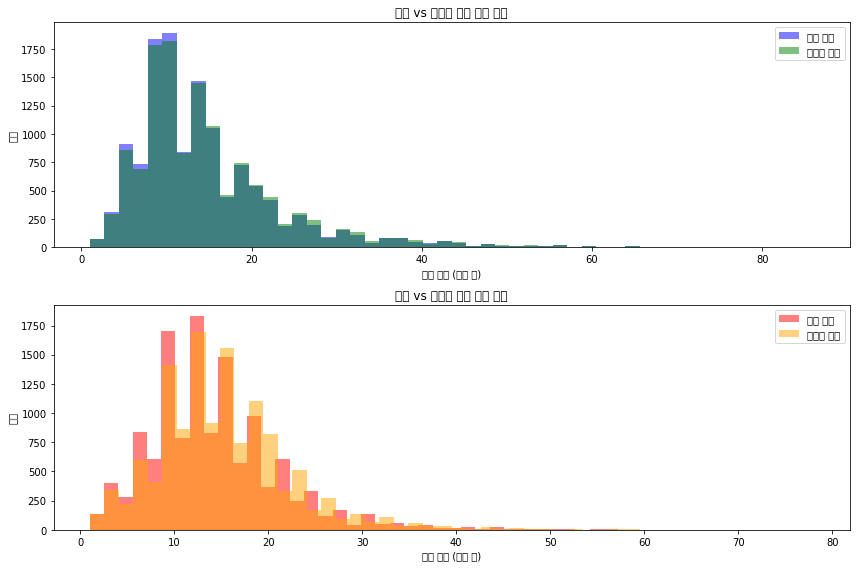


문제가 있는 전처리 케이스:


In [11]:
def evaluate_preprocessing(original_df, processed_df):
    """전처리 결과 검증 및 평가"""
    logger.info("전처리 결과 검증 및 평가 중...")
    
    evaluation_results = {
        "total_rows": len(processed_df),
        "empty_processed_q": 0,
        "empty_processed_a": 0,
        "short_processed_q": 0,
        "short_processed_a": 0,
        "avg_original_q_length": 0,
        "avg_processed_q_length": 0,
        "avg_original_a_length": 0,
        "avg_processed_a_length": 0,
        "morpheme_tokenization_success": 0
    }
    
    # 기본 통계
    evaluation_results["avg_original_q_length"] = original_df['Q'].apply(len).mean()
    evaluation_results["avg_original_a_length"] = original_df['A'].apply(len).mean()
    evaluation_results["avg_processed_q_length"] = processed_df['Q_processed'].apply(len).mean()
    evaluation_results["avg_processed_a_length"] = processed_df['A_processed'].apply(len).mean()
    
    # 빈 값 검사
    evaluation_results["empty_processed_q"] = (processed_df['Q_processed'].str.strip() == "").sum()
    evaluation_results["empty_processed_a"] = (processed_df['A_processed'].str.strip() == "").sum()
    
    # 짧은 텍스트 검사 (2단어 미만)
    evaluation_results["short_processed_q"] = (processed_df['Q_processed'].apply(lambda x: len(x.split()) < 2 if isinstance(x, str) else True)).sum()
    evaluation_results["short_processed_a"] = (processed_df['A_processed'].apply(lambda x: len(x.split()) < 2 if isinstance(x, str) else True)).sum()
    
    # 형태소 분석 성공률
    non_empty_morphemes_q = ~(processed_df['Q_morphemes'].isnull() | (processed_df['Q_morphemes'] == ""))
    non_empty_morphemes_a = ~(processed_df['A_morphemes'].isnull() | (processed_df['A_morphemes'] == ""))
    evaluation_results["morpheme_tokenization_success"] = (non_empty_morphemes_q & non_empty_morphemes_a).sum()
    
    # 결과 출력
    print("\n전처리 결과 평가:")
    print(f"총 데이터 수: {evaluation_results['total_rows']}")
    print(f"빈 처리 질문 수: {evaluation_results['empty_processed_q']} ({evaluation_results['empty_processed_q']/evaluation_results['total_rows']*100:.2f}%)")
    print(f"빈 처리 답변 수: {evaluation_results['empty_processed_a']} ({evaluation_results['empty_processed_a']/evaluation_results['total_rows']*100:.2f}%)")
    print(f"짧은 처리 질문 수: {evaluation_results['short_processed_q']} ({evaluation_results['short_processed_q']/evaluation_results['total_rows']*100:.2f}%)")
    print(f"짧은 처리 답변 수: {evaluation_results['short_processed_a']} ({evaluation_results['short_processed_a']/evaluation_results['total_rows']*100:.2f}%)")
    print(f"원본 질문 평균 길이: {evaluation_results['avg_original_q_length']:.2f} 글자")
    print(f"처리 질문 평균 길이: {evaluation_results['avg_processed_q_length']:.2f} 글자")
    print(f"원본 답변 평균 길이: {evaluation_results['avg_original_a_length']:.2f} 글자")
    print(f"처리 답변 평균 길이: {evaluation_results['avg_processed_a_length']:.2f} 글자")
    print(f"형태소 분석 성공률: {evaluation_results['morpheme_tokenization_success']/evaluation_results['total_rows']*100:.2f}%")
    
    # 원본과 처리된 텍스트 비교 시각화
    plt.figure(figsize=(12, 8))
    
    # 질문 길이 비교
    plt.subplot(2, 1, 1)
    plt.hist(original_df['Q'].apply(len), bins=50, alpha=0.5, color='blue', label='원본 질문')
    plt.hist(processed_df['Q_processed'].apply(len), bins=50, alpha=0.5, color='green', label='처리된 질문')
    plt.xlabel('문장 길이 (글자 수)')
    plt.ylabel('빈도')
    plt.title('원본 vs 처리된 질문 길이 분포')
    plt.legend()
    
    # 답변 길이 비교
    plt.subplot(2, 1, 2)
    plt.hist(original_df['A'].apply(len), bins=50, alpha=0.5, color='red', label='원본 답변')
    plt.hist(processed_df['A_processed'].apply(len), bins=50, alpha=0.5, color='orange', label='처리된 답변')
    plt.xlabel('문장 길이 (글자 수)')
    plt.ylabel('빈도')
    plt.title('원본 vs 처리된 답변 길이 분포')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(data_dir, 'preprocessing_evaluation.png'))
    plt.show()
    
    return evaluation_results

# 전처리 결과 분석
evaluation_results = evaluate_preprocessing(combined_df, processed_df)

# 문제 케이스 확인
def show_problematic_cases(df, n=10):
    """문제가 있는 전처리 케이스 보여주기"""
    print("\n문제가 있는 전처리 케이스:")
    
    # 빈 처리 결과 케이스
    empty_processed = df[(df['Q_processed'].str.strip() == "") | (df['A_processed'].str.strip() == "")]
    if len(empty_processed) > 0:
        print("\n빈 처리 결과 케이스:")
        for i, row in empty_processed.head(n).iterrows():
            print(f"원본 Q: {row['Q']}")
            print(f"처리 Q: {row['Q_processed']}")
            print(f"원본 A: {row['A']}")
            print(f"처리 A: {row['A_processed']}")
            print("-" * 50)
    
    # 심하게 변경된 케이스 (길이가 50% 이상 줄어든 경우)
    def length_reduction_ratio(orig, proc):
        if not isinstance(orig, str) or not isinstance(proc, str) or len(orig) == 0:
            return 0
        return (len(orig) - len(proc)) / len(orig)
    
    df['q_reduction'] = df.apply(lambda x: length_reduction_ratio(x['Q'], x['Q_processed']), axis=1)
    df['a_reduction'] = df.apply(lambda x: length_reduction_ratio(x['A'], x['A_processed']), axis=1)
    
    heavily_reduced = df[(df['q_reduction'] > 0.5) | (df['a_reduction'] > 0.5)]
    if len(heavily_reduced) > 0:
        print("\n심하게 변경된 케이스 (길이 50% 이상 감소):")
        for i, row in heavily_reduced.head(n).iterrows():
            print(f"원본 Q: {row['Q']}")
            print(f"처리 Q: {row['Q_processed']} (감소율: {row['q_reduction']:.2f})")
            print(f"원본 A: {row['A']}")
            print(f"처리 A: {row['A_processed']} (감소율: {row['a_reduction']:.2f})")
            print("-" * 50)

# 문제 케이스 확인
show_problematic_cases(processed_df)

### 1-12 최종 데이터 품질 개선 및 저장

In [12]:
def improve_data_quality(df):
    """데이터 품질 개선 - 개선된 버전"""
    logger.info("데이터 품질 개선 중...")
    
    # 처리 전 데이터 크기
    initial_size = len(df)
    
    # 1. 완전히 빈 처리 결과만 제거 (매우 관대한 필터링)
    df = df[~((df['Q_processed'].isnull()) | (df['A_processed'].isnull()))]
    
    # 2. 매우 짧은 처리 결과만 제거 (1글자 이하)
    df = df[~((df['Q_processed'].apply(lambda x: len(str(x)) <= 1)) & 
             (df['A_processed'].apply(lambda x: len(str(x)) <= 1)))]
    
    # 3. 중복 제거 (Q와 A가 모두 동일한 경우만)
    df = df.drop_duplicates(subset=['Q_processed', 'A_processed'])
    
    # 처리 후 데이터 크기
    final_size = len(df)
    
    logger.info(f"데이터 품질 개선 완료: {initial_size}개 -> {final_size}개 ({final_size/initial_size*100:.2f}%)")
    return df

# 데이터 품질 개선
improved_df = improve_data_quality(processed_df)

# 최종 데이터셋 저장
final_output_path = os.path.join(data_dir, 'final_preprocessed_chat_data.csv')
improved_df.to_csv(final_output_path, index=False)
logger.info(f"최종 전처리 데이터 저장 완료: {final_output_path}")

# 최종 데이터 통계
final_stats = {
    "원본 데이터 크기": len(combined_df),
    "처리 데이터 크기": len(processed_df),
    "최종 데이터 크기": len(improved_df),
    "데이터 보존율": len(improved_df) / len(combined_df) * 100
}

print("\n최종 데이터셋 통계:")
for key, value in final_stats.items():
    print(f"{key}: {value:.2f}" if isinstance(value, float) else f"{key}: {value}")

# 최종 데이터 샘플 출력
print("\n최종 데이터셋 샘플:")
display_columns = ['Q', 'Q_processed', 'Q_morphemes', 'A', 'A_processed', 'A_morphemes']
print(improved_df[display_columns].head())

2025-04-21 01:55:00,879 - __main__ - INFO - 데이터 품질 개선 중...
2025-04-21 01:55:00,903 - __main__ - INFO - 데이터 품질 개선 완료: 12770개 -> 12767개 (99.98%)
2025-04-21 01:55:00,995 - __main__ - INFO - 최종 전처리 데이터 저장 완료: chatbot_data/final_preprocessed_chat_data.csv



최종 데이터셋 통계:
원본 데이터 크기: 12770
처리 데이터 크기: 12770
최종 데이터 크기: 12767
데이터 보존율: 99.98

최종 데이터셋 샘플:
                 Q      Q_processed             Q_morphemes            A  \
0           12시 땡!          12시 땡 !                12 시 땡 !   하루가 또 가네요.   
1      1지망 학교 떨어졌어      1지망 학교 떨어졌어           1 지망 학교 떨어졌 어    위로해 드립니다.   
2     3박4일 놀러가고 싶다     3박4일 놀러가고 싶다     3 박 4 일 놀 러 가 고 싶 다  여행은 언제나 좋죠.   
3  3박4일 정도 놀러가고 싶다  3박4일 정도 놀러가고 싶다  3 박 4 일 정도 놀 러 가 고 싶 다  여행은 언제나 좋죠.   
4          PPL 심하네          PPL 심하네                PPL 심하 네   눈살이 찌푸려지죠.   

    A_processed     A_morphemes  
0   하루가 또 가네요 .   하루 가 또 가 네요 .  
1    위로해 드립니다 .     위로 해 드립니다 .  
2  여행은 언제나 좋죠 .  여행 은 언제나 좋 죠 .  
3  여행은 언제나 좋죠 .  여행 은 언제나 좋 죠 .  
4   눈살이 찌푸려지죠 .  눈살 이 찌푸려 지 죠 .  


### 1-13 메타데이터 및 프로젝트 정보 저장

In [13]:
def save_project_metadata():
    """프로젝트 메타데이터 저장"""
    logger.info("프로젝트 메타데이터 저장 중...")
    
    # 프로젝트 메타데이터
    metadata = {
        "project_name": "한국어 챗봇 개발",
        "step": "데이터 수집 및 전처리",
        "created_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "data_stats": {
            "original_data_size": len(combined_df),
            "processed_data_size": len(processed_df),
            "final_data_size": len(improved_df),
            "data_preservation_rate": len(improved_df) / len(combined_df) * 100
        },
        "preprocessing_pipeline": {
            "tools": {
                "morpheme_analyzer": str(preprocessor.morpheme_analyzer.__class__.__name__),
                "use_soynlp": preprocessor.use_soynlp
            },
            "stopwords_count": len(preprocessor.stopwords),
            "slang_dict_count": len(preprocessor.slang_dict)
        },
        "embedding_models": {
            "word2vec": embedding_manager.word2vec_model is not None,
            "fasttext": embedding_manager.fasttext_model is not None,
            "bert": bert_embedding.is_model_loaded()
        },
        "dialogue_context": {
            "conversations_count": len(dialogue_manager.conversation_flows),
            "max_context_length": dialogue_manager.max_context_length
        },
        "file_paths": {
            "combined_data": os.path.join(data_dir, 'combined_chat_data.csv'),
            "processed_data": os.path.join(data_dir, 'processed_chat_data.csv'),
            "final_data": os.path.join(data_dir, 'final_preprocessed_chat_data.csv'),
            "word2vec_model": os.path.join(data_dir, 'word2vec_model.bin'),
            "fasttext_model": os.path.join(data_dir, 'fasttext_model.bin'),
            "structured_dialogue": os.path.join(data_dir, 'structured_dialogue_data.json'),
            "context_qa_pairs": os.path.join(data_dir, 'context_qa_pairs.json')
        }
    }
    
    # 메타데이터 저장
    metadata_path = os.path.join(data_dir, 'project_metadata.json')
    with open(metadata_path, 'w', encoding='utf-8') as f:
        json.dump(metadata, f, ensure_ascii=False, indent=2)
    
    logger.info(f"프로젝트 메타데이터 저장 완료: {metadata_path}")
    return metadata

# 프로젝트 메타데이터 저장
metadata = save_project_metadata()

print("\n프로젝트 메타데이터:")
for key, value in metadata.items():
    if key != "file_paths":  # 파일 경로는 너무 길어서 제외
        print(f"{key}: {value}")

2025-04-21 01:55:01,014 - __main__ - INFO - 프로젝트 메타데이터 저장 중...
2025-04-21 01:55:01,015 - __main__ - INFO - 프로젝트 메타데이터 저장 완료: chatbot_data/project_metadata.json



프로젝트 메타데이터:
project_name: 한국어 챗봇 개발
step: 데이터 수집 및 전처리
created_at: 2025-04-21 01:55:01
data_stats: {'original_data_size': 12770, 'processed_data_size': 12770, 'final_data_size': 12767, 'data_preservation_rate': 99.97650743931088}
preprocessing_pipeline: {'tools': {'morpheme_analyzer': 'Mecab', 'use_soynlp': True}, 'stopwords_count': 17, 'slang_dict_count': 30}
embedding_models: {'word2vec': True, 'fasttext': True, 'bert': True}
dialogue_context: {'conversations_count': 200, 'max_context_length': 3}


## Step 2. 데이터 증강 및 토큰화 개선

- data 증강: 주제, 감정, 동의어, 백트랜슬레이션, 문장 패턴 etc. 적용하여 dataset 2배 가까이 확장
- 한국어 형태소 기반의 서브워드 토크나이저를 구축 (자연스러운 문장 분해와 재구성이 가능하도록)
- 결과: 증강 data와 토큰화 data 모두 성공적으로 생성&저장

### 2-1 필요 라이브러리 임포트 및 환경 설정

In [14]:
# 추가로 필요한 라이브러리 임포트
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.util import ngrams
import seaborn as sns
import itertools
import math

# 데이터 디렉토리 설정 
data_dir = "chatbot_data"
os.makedirs(data_dir, exist_ok=True)

# 랜덤 시드 설정 
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# NLTK 데이터 다운로드 (새로 필요한 부분)
try:
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
except:
    logger.warning("NLTK 데이터 다운로드 실패. 이미 설치되어 있거나 네트워크 문제일 수 있습니다.")


### 2-2 데이터 로드 및 전처리 결과 확인

In [15]:
def load_processed_data():
    """Step1에서 전처리한 데이터 로드"""
    logger.info("전처리된 데이터 로드 중...")
    
    # 최종 전처리된 데이터 로드
    processed_data_path = os.path.join(data_dir, 'final_preprocessed_chat_data.csv')
    
    if os.path.exists(processed_data_path):
        df = pd.read_csv(processed_data_path)
        logger.info(f"전처리된 데이터 로드 완료: {len(df)}개")
        return df
    else:
        # 전처리된 데이터가 없는 경우 원본 데이터 로드
        logger.warning("전처리된 데이터를 찾을 수 없습니다. 원본 데이터를 로드합니다.")
        combined_data_path = os.path.join(data_dir, 'combined_chat_data.csv')
        
        if os.path.exists(combined_data_path):
            df = pd.read_csv(combined_data_path)
            logger.info(f"원본 데이터 로드 완료: {len(df)}개")
            return df
        else:
            logger.error("데이터 파일을 찾을 수 없습니다.")
            return None

# 전처리된 데이터 로드
processed_df = load_processed_data()

if processed_df is not None:
    print("데이터셋 미리보기:")
    print(processed_df.head())
    
    # 데이터 통계 출력
    print(f"\n데이터셋 크기: {len(processed_df)}")
    
    # 컬럼 확인
    print(f"데이터셋 컬럼: {processed_df.columns.tolist()}")
    
    # 질문/답변 길이 분포
    q_lengths = processed_df['Q_processed'].apply(lambda x: len(str(x).split()))
    a_lengths = processed_df['A_processed'].apply(lambda x: len(str(x).split()))
    
    print(f"질문 평균 단어 수: {q_lengths.mean():.2f}")
    print(f"질문 최대 단어 수: {q_lengths.max()}")
    print(f"답변 평균 단어 수: {a_lengths.mean():.2f}")
    print(f"답변 최대 단어 수: {a_lengths.max()}")
    
    # 형태소 분석 결과 확인
    print("\n형태소 분석 결과 샘플:")
    for i in range(min(5, len(processed_df))):
        print(f"원문 Q: {processed_df.iloc[i]['Q']}")
        print(f"형태소 Q: {processed_df.iloc[i]['Q_morphemes']}")
        print(f"원문 A: {processed_df.iloc[i]['A']}")
        print(f"형태소 A: {processed_df.iloc[i]['A_morphemes']}")
        print("-" * 50)
    
    # 데이터 추출
    questions = processed_df['Q_processed'].tolist()
    answers = processed_df['A_processed'].tolist()
    questions_morpheme = processed_df['Q_morphemes'].tolist()
    answers_morpheme = processed_df['A_morphemes'].tolist()
    
    logger.info(f"질문-답변 쌍 {len(questions)}개 추출 완료")
else:
    logger.error("데이터 로드 실패. 프로그램을 종료합니다.")
    exit(1)

2025-04-21 02:09:46,267 - __main__ - INFO - 전처리된 데이터 로드 중...
2025-04-21 02:09:46,356 - __main__ - INFO - 전처리된 데이터 로드 완료: 12767개
2025-04-21 02:09:46,388 - __main__ - INFO - 질문-답변 쌍 12767개 추출 완료


데이터셋 미리보기:
                 Q            A  source      Q_processed   A_processed  \
0           12시 땡!   하루가 또 가네요.  songys          12시 땡 !   하루가 또 가네요 .   
1      1지망 학교 떨어졌어    위로해 드립니다.  songys      1지망 학교 떨어졌어    위로해 드립니다 .   
2     3박4일 놀러가고 싶다  여행은 언제나 좋죠.  songys     3박4일 놀러가고 싶다  여행은 언제나 좋죠 .   
3  3박4일 정도 놀러가고 싶다  여행은 언제나 좋죠.  songys  3박4일 정도 놀러가고 싶다  여행은 언제나 좋죠 .   
4          PPL 심하네   눈살이 찌푸려지죠.  songys          PPL 심하네   눈살이 찌푸려지죠 .   

              Q_morphemes     A_morphemes  q_reduction  a_reduction  
0                12 시 땡 !   하루 가 또 가 네요 .    -0.166667    -0.100000  
1           1 지망 학교 떨어졌 어     위로 해 드립니다 .     0.000000    -0.111111  
2     3 박 4 일 놀 러 가 고 싶 다  여행 은 언제나 좋 죠 .     0.000000    -0.090909  
3  3 박 4 일 정도 놀 러 가 고 싶 다  여행 은 언제나 좋 죠 .     0.000000    -0.090909  
4                PPL 심하 네  눈살 이 찌푸려 지 죠 .     0.000000    -0.100000  

데이터셋 크기: 12767
데이터셋 컬럼: ['Q', 'A', 'source', 'Q_processed', 'A_processed', 'Q_morphemes', 'A_morphemes', 'q_reduction', 'a_

### 2-3 텍스트 분석 및 분류 기능 구현

In [16]:
class TextAnalyzer:
    """텍스트 분석 및 분류 클래스"""
    
    def __init__(self):
        # 주제별 키워드 정의
        self.topic_keywords = {
            '학업': ['시험', '공부', '학교', '숙제', '성적', '교수', '학생', '강의', '수업', '과제', '논문', '발표', '연구', '전공', '학점'],
            '건강': ['아프다', '병원', '운동', '다이어트', '피곤', '건강', '약', '치료', '증상', '통증', '두통', '감기', '질병', '영양', '수면'],
            '연애': ['좋아해', '사랑', '고백', '썸', '이별', '남자친구', '여자친구', '연인', '데이트', '결혼', '짝사랑', '이혼', '소개팅', '썸', '고백'],
            '일상': ['밥', '날씨', '쇼핑', '영화', '여행', '취미', '휴식', '주말', '요리', '음식', '카페', '집', '친구', '가족', '생일'],
            '감정': ['기쁘다', '슬프다', '화나다', '불안', '걱정', '우울', '행복', '스트레스', '분노', '기쁨', '슬픔', '후회', '불만', '만족', '실망'],
            '직장': ['회사', '업무', '상사', '동료', '퇴근', '출근', '프로젝트', '이직', '연봉', '승진', '퇴사', '취업', '면접', '경력', '직무'],
            '취미': ['게임', '독서', '음악', '영화', '드라마', '공연', '전시', '여행', '요리', '스포츠', '사진', '그림', '춤', '노래', '악기'],
            '사회': ['뉴스', '정치', '경제', '사회', '문화', '환경', '기술', '과학', '법률', '교육', '복지', '인권', '국제', '역사', '종교']
        }
        
        # 감정 키워드 정의
        self.emotion_keywords = {
            '기쁨': ['좋아', '행복', '신나', '즐거워', '기뻐', '웃', '신남', '좋았', '재밌', '설레', '만족', '감사', '흥분', '기쁘', '즐거움'],
            '슬픔': ['슬퍼', '우울', '힘들어', '아파', '눈물', '울', '서럽', '그리움', '외로움', '쓸쓸', '공허', '상실', '아쉬움', '실망', '허무'],
            '분노': ['화나', '짜증', '열받아', '미쳐', '짜증나', '화가', '분노', '억울', '답답', '불만', '격분', '증오', '혐오', '불쾌', '격노'],
            '불안': ['걱정', '불안', '긴장', '두려워', '무서워', '겁나', '조마조마', '떨려', '초조', '스트레스', '공포', '당황', '놀람', '충격', '혼란'],
            '중립': ['그냥', '보통', '평범', '일상', '특별하지않아', '괜찮', '그저', '별거', '무난', '적당', '보통', '평이', '중간', '보편적', '일반적']
        }
        
        # 문장 유형 패턴 정의
        self.sentence_patterns = {
            '질문': [r'\?', r'까\?', r'니\?', r'세요\?', r'어떻', r'언제', r'누구', r'무엇', r'왜', r'어디', r'몇', r'얼마'],
            '명령': [r'해주세요', r'하세요', r'해봐', r'해라', r'해줘', r'해봐요', r'하지마', r'하지마세요', r'해야해'],
            '감탄': [r'\!', r'와\!', r'우와', r'대박', r'신기', r'멋지', r'놀라', r'감동', r'최고'],
            '서술': [r'이다', r'입니다', r'예요', r'이에요', r'이야', r'이네', r'이네요', r'군요', r'구나']
        }
        
        # TF-IDF 벡터라이저 초기화
        self.tfidf_vectorizer = None
        
        logger.info("텍스트 분석기 초기화 완료")
    
    def classify_topic(self, text):
        """주제 분류 함수"""
        if not text or not isinstance(text, str):
            return '일반'
        
        # 주제 점수 계산
        topic_scores = {}
        for topic, keywords in self.topic_keywords.items():
            # 키워드 매칭 점수
            keyword_score = sum(1 for keyword in keywords if keyword in text)
            
            # 단어 유사도 점수 (단어 포함 여부)
            word_score = sum(1 for word in text.split() for keyword in keywords 
                            if keyword in word or word in keyword)
            
            # 최종 점수 계산 (키워드 매칭에 더 높은 가중치)
            topic_scores[topic] = keyword_score * 2 + word_score
        
        # 가장 높은 점수의 주제 반환
        max_score = max(topic_scores.values()) if topic_scores else 0
        
        # 점수가 0이거나 매우 낮으면 '일반' 반환
        if max_score <= 1:
            return '일반'
        
        # 가장 높은 점수의 주제 반환
        return max(topic_scores.items(), key=lambda x: x[1])[0]
    
    def analyze_emotion(self, text):
        """감정 분석 함수"""
        if not text or not isinstance(text, str):
            return '중립'
        
        # 감정 점수 계산
        emotion_scores = {}
        for emotion, keywords in self.emotion_keywords.items():
            # 키워드 매칭 점수
            keyword_score = sum(1 for keyword in keywords if keyword in text)
            
            # 단어 유사도 점수
            word_score = sum(1 for word in text.split() for keyword in keywords 
                            if keyword in word or word in keyword)
            
            # 최종 점수 계산
            emotion_scores[emotion] = keyword_score * 2 + word_score
        
        # 가장 높은 점수의 감정 반환
        max_score = max(emotion_scores.values()) if emotion_scores else 0
        
        # 점수가 0이거나 매우 낮으면 '중립' 반환
        if max_score <= 1:
            return '중립'
        
        # 가장 높은 점수의 감정 반환
        return max(emotion_scores.items(), key=lambda x: x[1])[0]
    
    def classify_sentence_type(self, text):
        """문장 유형 분류 함수"""
        if not text or not isinstance(text, str):
            return '서술'
        
        # 문장 유형 점수 계산
        type_scores = {}
        for sent_type, patterns in self.sentence_patterns.items():
            # 패턴 매칭 점수
            score = sum(1 for pattern in patterns if re.search(pattern, text))
            type_scores[sent_type] = score
        
        # 가장 높은 점수의 문장 유형 반환
        max_score = max(type_scores.values()) if type_scores else 0
        
        # 점수가 0이면 '서술' 반환
        if max_score == 0:
            return '서술'
        
        # 가장 높은 점수의 문장 유형 반환
        return max(type_scores.items(), key=lambda x: x[1])[0]
    
    def fit_tfidf_vectorizer(self, texts):
        """TF-IDF 벡터라이저 학습"""
        if not texts:
            logger.warning("TF-IDF 벡터라이저 학습을 위한 텍스트가 없습니다.")
            return
        
        logger.info("TF-IDF 벡터라이저 학습 중...")
        self.tfidf_vectorizer = TfidfVectorizer(
            min_df=2,
            max_df=0.9,
            max_features=10000,
            ngram_range=(1, 2),
            sublinear_tf=True
        )
        self.tfidf_vectorizer.fit(texts)
        logger.info(f"TF-IDF 벡터라이저 학습 완료 (특성 수: {len(self.tfidf_vectorizer.get_feature_names_out())})")
    
    def get_text_similarity(self, text1, text2):
        """두 텍스트 간의 유사도 계산"""
        if not self.tfidf_vectorizer:
            logger.warning("TF-IDF 벡터라이저가 학습되지 않았습니다.")
            return 0.0
        
        if not text1 or not text2 or not isinstance(text1, str) or not isinstance(text2, str):
            return 0.0
        
        # TF-IDF 벡터 변환
        try:
            tfidf_matrix = self.tfidf_vectorizer.transform([text1, text2])
            # 코사인 유사도 계산
            similarity = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]
            return similarity
        except Exception as e:
            logger.error(f"유사도 계산 중 오류: {e}")
            return 0.0
    
    def analyze_text(self, text):
        """텍스트 종합 분석"""
        if not text or not isinstance(text, str):
            return {
                'topic': '일반',
                'emotion': '중립',
                'sentence_type': '서술',
                'word_count': 0,
                'char_count': 0
            }
        
        # 단어 수 및 문자 수 계산
        word_count = len(text.split())
        char_count = len(text)
        
        # 종합 분석 결과 반환
        return {
            'topic': self.classify_topic(text),
            'emotion': self.analyze_emotion(text),
            'sentence_type': self.classify_sentence_type(text),
            'word_count': word_count,
            'char_count': char_count
        }

# 텍스트 분석기 초기화
text_analyzer = TextAnalyzer()

# TF-IDF 벡터라이저 학습
text_analyzer.fit_tfidf_vectorizer(questions + answers)

# 텍스트 분석 테스트
print("\n텍스트 분석 테스트:")
test_texts = [
    "오늘 시험을 망쳐서 너무 슬퍼요. 어떻게 해야 할까요?",
    "남자친구가 생일 선물로 뭘 주면 좋을까요?",
    "요즘 날씨가 너무 좋아서 기분이 좋아요!",
    "회사에서 상사가 자꾸 괴롭혀서 스트레스 받아요.",
    "오늘 저녁 뭐 먹을까요?"
]

for text in test_texts:
    analysis = text_analyzer.analyze_text(text)
    print(f"텍스트: {text}")
    print(f"주제: {analysis['topic']}")
    print(f"감정: {analysis['emotion']}")
    print(f"문장 유형: {analysis['sentence_type']}")
    print(f"단어 수: {analysis['word_count']}")
    print("-" * 50)

2025-04-21 02:09:53,025 - __main__ - INFO - 텍스트 분석기 초기화 완료
2025-04-21 02:09:53,027 - __main__ - INFO - TF-IDF 벡터라이저 학습 중...
2025-04-21 02:09:53,470 - __main__ - INFO - TF-IDF 벡터라이저 학습 완료 (특성 수: 10000)



텍스트 분석 테스트:
텍스트: 오늘 시험을 망쳐서 너무 슬퍼요. 어떻게 해야 할까요?
주제: 학업
감정: 슬픔
문장 유형: 질문
단어 수: 8
--------------------------------------------------
텍스트: 남자친구가 생일 선물로 뭘 주면 좋을까요?
주제: 일상
감정: 중립
문장 유형: 질문
단어 수: 6
--------------------------------------------------
텍스트: 요즘 날씨가 너무 좋아서 기분이 좋아요!
주제: 일상
감정: 기쁨
문장 유형: 감탄
단어 수: 6
--------------------------------------------------
텍스트: 회사에서 상사가 자꾸 괴롭혀서 스트레스 받아요.
주제: 직장
감정: 불안
문장 유형: 서술
단어 수: 6
--------------------------------------------------
텍스트: 오늘 저녁 뭐 먹을까요?
주제: 일반
감정: 중립
문장 유형: 질문
단어 수: 4
--------------------------------------------------


### 2-4 데이터 증강 클래스 구현

In [17]:
class DataAugmenter:
    """한국어 데이터 증강 클래스"""
    
    def __init__(self, text_analyzer=None):
        self.text_analyzer = text_analyzer
        
        # 한국어 조사/어미 변형 사전
        self.korean_particles = {
            '은': '는', '는': '은', 
            '이': '가', '가': '이',
            '을': '를', '를': '을',
            '과': '와', '와': '과'
        }
        
        # 한국어 동의어 사전
        self.synonyms = {
            # 감정 표현
            '좋아': ['마음에 들어', '괜찮아', '훌륭해', '맘에 들어'],
            '싫어': ['마음에 안 들어', '별로야', '안 좋아', '맘에 안 들어'],
            '행복': ['기쁨', '즐거움', '좋은 기분', '만족'],
            '슬픔': ['우울함', '서러움', '마음 아픔', '쓸쓸함'],
            '화나': ['짜증나', '열받아', '분노', '불쾌'],
            '걱정': ['불안', '염려', '근심', '고민'],
            '사랑': ['좋아함', '애정', '마음', '호감'],
            '미워': ['싫어함', '증오', '반감', '혐오'],
            
            # 일상 표현
            '먹다': ['식사하다', '섭취하다', '맛보다', '드시다'],
            '자다': ['수면하다', '눕다', '쉬다', '취침하다'],
            '말하다': ['이야기하다', '얘기하다', '대화하다', '설명하다'],
            '보다': ['관찰하다', '확인하다', '살펴보다', '구경하다'],
            '듣다': ['경청하다', '청취하다', '들리다', '귀담아듣다'],
            '가다': ['이동하다', '방문하다', '향하다', '출발하다'],
            '오다': ['도착하다', '방문하다', '찾아오다', '다가오다'],
            '웃다': ['미소짓다', '즐거워하다', '기뻐하다', '흐뭇해하다'],
            '울다': ['눈물짓다', '흐느끼다', '슬퍼하다', '서러워하다'],
            
            # 시간 표현
            '오늘': ['금일', '지금', '현재', '이날'],
            '내일': ['명일', '다음날', '익일', '내일모레'],
            '어제': ['전일', '지난날', '하루 전', '어젯밤'],
            '지금': ['현재', '이때', '이 순간', '당장'],
            '나중': ['이후', '후에', '뒤에', '앞으로'],
            
            # 정도 표현
            '매우': ['아주', '너무', '굉장히', '정말'],
            '조금': ['약간', '살짝', '다소', '약간'],
            '많이': ['잔뜩', '한참', '가득', '다량'],
            '적게': ['소량', '조금', '약간', '몇 안 되게'],
            
            # 인사 표현
            '안녕': ['반가워', '잘 지내', '안녕하세요', '반갑습니다'],
            '고마워': ['감사해', '고맙습니다', '감사합니다', '감사'],
            '미안해': ['죄송해', '미안합니다', '죄송합니다', '사과드립니다'],
            '축하해': ['축하합니다', '축하드려요', '기쁘게 생각해요', '경하를 표합니다']
        }
        
        # 문장 패턴 변환 사전
        self.sentence_patterns = {
            # 질문 패턴
            '(?P<text>.+)\?': [
                '혹시 {text}?', 
                '{text}...?', 
                '정말 {text}?',
                '혹시나 {text}?',
                '그럼 {text}?'
            ],
            
            # 서술 패턴
            '나는 (?P<text>.+)': [
                '저는 {text}', 
                '제가 {text}', 
                '나는 말이야, {text}',
                '제 경우는 {text}',
                '나로 말하자면 {text}'
            ],
            
            # 감정 표현 패턴
            '(?P<text>.+) 좋아': [
                '{text} 마음에 들어', 
                '{text} 괜찮아', 
                '{text} 훌륭해',
                '{text} 좋네요',
                '{text} 맘에 들어'
            ],
            
            # 부정 표현 패턴
            '(?P<text>.+) 싫어': [
                '{text} 마음에 안 들어', 
                '{text} 별로야', 
                '{text} 안 좋아',
                '{text} 싫네요',
                '{text} 맘에 안 들어'
            ]
        }
        
        logger.info("데이터 증강기 초기화 완료")
    
    def swap_particles(self, text):
        """한국어 조사/어미 변형"""
        if not text or not isinstance(text, str):
            return text
        
        words = text.split()
        for i, word in enumerate(words):
            for particle1, particle2 in self.korean_particles.items():
                if word.endswith(particle1):
                    words[i] = word[:-len(particle1)] + particle2
                    break
        
        return ' '.join(words)
    
    def replace_with_synonyms(self, text, probability=0.5):
        """동의어 대체"""
        if not text or not isinstance(text, str):
            return text
        
        words = text.split()
        for i, word in enumerate(words):
            for key, synonyms in self.synonyms.items():
                if key in word and random.random() < probability:
                    # 동의어 중 하나를 무작위로 선택
                    replacement = random.choice(synonyms)
                    words[i] = word.replace(key, replacement)
                    break
        
        return ' '.join(words)
    
    def apply_pattern_transformation(self, text):
        """문장 패턴 변환"""
        if not text or not isinstance(text, str):
            return text
        
        for pattern, replacements in self.sentence_patterns.items():
            match = re.match(pattern, text)
            if match:
                # 패턴에 맞는 문장이면 변환 패턴 중 하나를 무작위로 선택
                replacement_pattern = random.choice(replacements)
                # 그룹 캡처한 텍스트 추출
                captured_text = match.group('text')
                # 새로운 패턴에 적용
                return replacement_pattern.format(text=captured_text)
        
        return text
    
    def back_translation_simulation(self, text):
        """백 트랜슬레이션 시뮬레이션 (실제 번역 API 없이 간단한 변형)"""
        if not text or not isinstance(text, str):
            return text
        
        # 1. 조사/어미 변형
        modified_text = self.swap_particles(text)
        
        # 2. 동의어 대체
        modified_text = self.replace_with_synonyms(modified_text, probability=0.3)
        
        # 3. 문장 패턴 변환 (50% 확률로 적용)
        if random.random() < 0.5:
            modified_text = self.apply_pattern_transformation(modified_text)
        
        # 원본과 동일하면 최소한의 변형 적용
        if modified_text == text:
            words = text.split()
            if len(words) > 3:
                # 단어 순서 약간 변경
                i, j = random.sample(range(len(words)), 2)
                words[i], words[j] = words[j], words[i]
                modified_text = ' '.join(words)
        
        return modified_text
    
    def generate_variations(self, text, num_variations=3):
        """텍스트 변형 생성"""
        if not text or not isinstance(text, str):
            return []
        
        variations = []
        for _ in range(num_variations):
            # 다양한 변형 방법 적용
            variation = text
            
            # 변형 방법 무작위 선택 (중복 가능)
            methods = random.choices([
                self.swap_particles,
                self.replace_with_synonyms,
                self.apply_pattern_transformation,
                self.back_translation_simulation
            ], k=random.randint(1, 3))
            
            # 선택된 변형 방법 적용
            for method in methods:
                variation = method(variation)
            
            # 원본과 다른 경우에만 추가
            if variation != text and variation not in variations:
                variations.append(variation)
        
        return variations
    
    def augment_by_topic(self, questions, answers, sample_ratio=0.2):
        """주제 기반 데이터 증강"""
        if not self.text_analyzer:
            logger.warning("텍스트 분석기가 설정되지 않았습니다. 주제 기반 증강을 건너뜁니다.")
            return [], []
        
        logger.info("주제 기반 데이터 증강 시작...")
        
        # 주제별 데이터 분류
        topic_data = defaultdict(list)
        
        # 샘플링하여 주제 분류 (전체 데이터의 sample_ratio만큼)
        sample_indices = random.sample(range(len(questions)), int(len(questions) * sample_ratio))
        
        for i in tqdm(sample_indices, desc="주제 분류"):
            topic = self.text_analyzer.classify_topic(questions[i])
            topic_data[topic].append((questions[i], answers[i]))
        
        # 증강된 데이터 저장
        augmented_questions = []
        augmented_answers = []
        
        # 주제별 데이터 증강
        for topic, qa_pairs in tqdm(topic_data.items(), desc="주제별 증강"):
            if len(qa_pairs) < 2:
                continue
            
            # 주제별 데이터 크기에 비례하여 증강 데이터 생성
            num_augmentations = min(len(qa_pairs) // 2, 50)  # 최대 50개까지 증강
            
            for _ in range(num_augmentations):
                # 무작위로 두 쌍 선택
                pair1, pair2 = random.sample(qa_pairs, 2)
                q1, a1 = pair1
                q2, a2 = pair2
                
                # 질문1-답변2 조합 (50% 확률)
                if random.random() < 0.5:
                    augmented_questions.append(q1)
                    augmented_answers.append(a2)
                # 질문2-답변1 조합 (50% 확률)
                else:
                    augmented_questions.append(q2)
                    augmented_answers.append(a1)
        
        logger.info(f"주제 기반 증강 완료: {len(augmented_questions)}개 생성")
        return augmented_questions, augmented_answers
    
    def augment_by_emotion(self, questions, answers, sample_ratio=0.2):
        """감정 기반 데이터 증강"""
        if not self.text_analyzer:
            logger.warning("텍스트 분석기가 설정되지 않았습니다. 감정 기반 증강을 건너뜁니다.")
            return [], []
        
        logger.info("감정 기반 데이터 증강 시작...")
        
        # 감정별 데이터 분류
        emotion_data = defaultdict(list)
        
        # 샘플링하여 감정 분류 (전체 데이터의 sample_ratio만큼)
        sample_indices = random.sample(range(len(questions)), int(len(questions) * sample_ratio))
        
        for i in tqdm(sample_indices, desc="감정 분류"):
            emotion = self.text_analyzer.analyze_emotion(questions[i])
            emotion_data[emotion].append((questions[i], answers[i]))
        
        # 증강된 데이터 저장
        augmented_questions = []
        augmented_answers = []
        
        # 감정별 데이터 증강
        for emotion, qa_pairs in tqdm(emotion_data.items(), desc="감정별 증강"):
            if len(qa_pairs) < 2:
                continue
            
            # 감정별 데이터 크기에 비례하여 증강 데이터 생성
            num_augmentations = min(len(qa_pairs) // 2, 30)  # 최대 30개까지 증강
            
            for _ in range(num_augmentations):
                # 무작위로 두 쌍 선택
                pair1, pair2 = random.sample(qa_pairs, 2)
                q1, a1 = pair1
                q2, a2 = pair2
                
                # 감정이 같은 질문-답변 쌍 교차 결합
                augmented_questions.append(q1)
                augmented_answers.append(a2)
        
        logger.info(f"감정 기반 증강 완료: {len(augmented_questions)}개 생성")
        return augmented_questions, augmented_answers
    
    def augment_by_sentence_type(self, questions, answers):
        """문장 유형 기반 데이터 증강"""
        if not self.text_analyzer:
            logger.warning("텍스트 분석기가 설정되지 않았습니다. 문장 유형 기반 증강을 건너뜁니다.")
            return [], []
        
        logger.info("문장 유형 기반 데이터 증강 시작...")
        
        # 문장 유형별 데이터 분류
        type_data = defaultdict(list)
        
        # 전체 데이터에 대해 문장 유형 분류
        for i in tqdm(range(len(questions)), desc="문장 유형 분류"):
            sent_type = self.text_analyzer.classify_sentence_type(questions[i])
            type_data[sent_type].append((questions[i], answers[i]))
        
        # 증강된 데이터 저장
        augmented_questions = []
        augmented_answers = []
        
        # 질문 유형의 데이터 증강 (질문-질문 쌍 생성)
        if '질문' in type_data and len(type_data['질문']) >= 2:
            question_pairs = type_data['질문']
            
            # 최대 100개까지 증강
            num_augmentations = min(len(question_pairs) // 2, 100)
            
            for _ in range(num_augmentations):
                # 무작위로 두 쌍 선택
                pair1, pair2 = random.sample(question_pairs, 2)
                q1, a1 = pair1
                q2, a2 = pair2
                
                # 질문에 대한 질문 생성
                if '?' in q1 and '?' in q2:
                    augmented_questions.append(q1)
                    augmented_answers.append(q2)
        
        logger.info(f"문장 유형 기반 증강 완료: {len(augmented_questions)}개 생성")
        return augmented_questions, augmented_answers
    
    def augment_by_word_replacement(self, questions, answers, sample_ratio=0.3):
        """단어 대체 기반 데이터 증강"""
        logger.info("단어 대체 기반 데이터 증강 시작...")
        
        # 증강된 데이터 저장
        augmented_questions = []
        augmented_answers = []
        
        # 샘플링하여 단어 대체 (전체 데이터의 sample_ratio만큼)
        sample_indices = random.sample(range(len(questions)), int(len(questions) * sample_ratio))
        
        for i in tqdm(sample_indices, desc="단어 대체 증강"):
            q = questions[i]
            a = answers[i]
            
            # 질문에 대한 변형 생성
            q_variations = self.generate_variations(q, num_variations=2)
            
            # 답변에 대한 변형 생성
            a_variations = self.generate_variations(a, num_variations=1)
            
            # 변형된 질문-원본 답변 쌍 추가
            for q_var in q_variations:
                augmented_questions.append(q_var)
                augmented_answers.append(a)
            
            # 원본 질문-변형된 답변 쌍 추가
            for a_var in a_variations:
                augmented_questions.append(q)
                augmented_answers.append(a_var)
        
        logger.info(f"단어 대체 기반 증강 완료: {len(augmented_questions)}개 생성")
        return augmented_questions, augmented_answers
    
    def augment_by_back_translation(self, questions, answers, sample_ratio=0.2):
        """백 트랜슬레이션 시뮬레이션 기반 데이터 증강"""
        logger.info("백 트랜슬레이션 시뮬레이션 기반 데이터 증강 시작...")
        
        # 증강된 데이터 저장
        augmented_questions = []
        augmented_answers = []
        
        # 샘플링하여 백 트랜슬레이션 시뮬레이션 (전체 데이터의 sample_ratio만큼)
        sample_indices = random.sample(range(len(questions)), int(len(questions) * sample_ratio))
        
        for i in tqdm(sample_indices, desc="백 트랜슬레이션 증강"):
            q = questions[i]
            a = answers[i]
            
            # 백 트랜슬레이션 시뮬레이션 적용
            q_bt = self.back_translation_simulation(q)
            a_bt = self.back_translation_simulation(a)
            
            # 원본과 다른 경우에만 추가
            if q_bt != q:
                augmented_questions.append(q_bt)
                augmented_answers.append(a)
            
            if a_bt != a:
                augmented_questions.append(q)
                augmented_answers.append(a_bt)
        
        logger.info(f"백 트랜슬레이션 시뮬레이션 기반 증강 완료: {len(augmented_questions)}개 생성")
        return augmented_questions, augmented_answers
    
    def augment_by_order_reversal(self, questions, answers, sample_ratio=0.1):
        """순서 뒤집기 기반 데이터 증강"""
        logger.info("순서 뒤집기 기반 데이터 증강 시작...")
        
        # 증강된 데이터 저장
        augmented_questions = []
        augmented_answers = []
        
        # 샘플링하여 순서 뒤집기 (전체 데이터의 sample_ratio만큼)
        sample_indices = random.sample(range(len(questions)), int(len(questions) * sample_ratio))
        
        for i in tqdm(sample_indices, desc="순서 뒤집기 증강"):
            q = questions[i]
            a = answers[i]
            
            # 답변이 질문이 될 수 있는 경우만 선택 (질문 형태가 아닌 경우)
            if not any(pattern in a for pattern in ['?', '까', '니까', '세요']):
                # 복잡한 문장만 선택하여 증강 (단어 수가 3개 이상인 경우)
                if len(q.split()) > 3 and len(a.split()) > 3:
                    augmented_questions.append(a)
                    augmented_answers.append(q)
        
        logger.info(f"순서 뒤집기 기반 증강 완료: {len(augmented_questions)}개 생성")
        return augmented_questions, augmented_answers
    
    def augment_data(self, questions, answers, methods=None):
        """데이터 증강 메인 함수"""
        logger.info("데이터 증강 시작...")
        
        # 기본 증강 방법 설정
        if methods is None:
            methods = [
                'topic',
                'emotion',
                'word_replacement',
                'back_translation',
                'order_reversal',
                'sentence_type'
            ]
        
        # 원본 데이터 복사
        augmented_questions = questions.copy()
        augmented_answers = answers.copy()
        
        # 증강 방법별 적용
        for method in methods:
            q_aug, a_aug = [], []
            
            if method == 'topic':
                q_aug, a_aug = self.augment_by_topic(questions, answers)
            elif method == 'emotion':
                q_aug, a_aug = self.augment_by_emotion(questions, answers)
            elif method == 'word_replacement':
                q_aug, a_aug = self.augment_by_word_replacement(questions, answers)
            elif method == 'back_translation':
                q_aug, a_aug = self.augment_by_back_translation(questions, answers)
            elif method == 'order_reversal':
                q_aug, a_aug = self.augment_by_order_reversal(questions, answers)
            elif method == 'sentence_type':
                q_aug, a_aug = self.augment_by_sentence_type(questions, answers)
            
            # 증강 데이터 추가
            augmented_questions.extend(q_aug)
            augmented_answers.extend(a_aug)
        
        # 중복 제거
        unique_pairs = set()
        unique_questions = []
        unique_answers = []
        
        for q, a in zip(augmented_questions, augmented_answers):
            pair = (q, a)
            if pair not in unique_pairs:
                unique_pairs.add(pair)
                unique_questions.append(q)
                unique_answers.append(a)
        
        logger.info(f"원본 데이터 크기: {len(questions)}")
        logger.info(f"증강 후 데이터 크기: {len(unique_questions)}")
        logger.info(f"증강 비율: {len(unique_questions) / len(questions):.2f}배")
        
        return unique_questions, unique_answers

# 데이터 증강기 초기화
data_augmenter = DataAugmenter(text_analyzer)

# 데이터 증강 적용
questions_augmented, answers_augmented = data_augmenter.augment_data(questions_morpheme, answers_morpheme)

# 증강 결과 샘플 출력
print("\n증강 데이터 샘플:")
for i in range(min(5, len(questions_augmented))):
    if i >= len(questions_morpheme):  # 새로 증강된 데이터인 경우
        print(f"[증강] 질문: {questions_augmented[i]}")
        print(f"[증강] 답변: {answers_augmented[i]}")
    else:  # 원본 데이터인 경우
        print(f"[원본] 질문: {questions_augmented[i]}")
        print(f"[원본] 답변: {answers_augmented[i]}")
    print("-" * 50)

# 증강 데이터 저장
augmented_data = pd.DataFrame({
    'Q': questions_augmented,
    'A': answers_augmented
})
augmented_data.to_csv(os.path.join(data_dir, 'augmented_data.csv'), index=False)
logger.info(f"증강 데이터 저장 완료: {os.path.join(data_dir, 'augmented_data.csv')}")

2025-04-21 02:10:05,526 - __main__ - INFO - 데이터 증강기 초기화 완료
2025-04-21 02:10:05,527 - __main__ - INFO - 데이터 증강 시작...
2025-04-21 02:10:05,528 - __main__ - INFO - 주제 기반 데이터 증강 시작...
주제별 증강: 100%|██████████| 9/9 [00:00<00:00, 8945.20it/s]
2025-04-21 02:10:05,730 - __main__ - INFO - 주제 기반 증강 완료: 329개 생성
2025-04-21 02:10:05,731 - __main__ - INFO - 감정 기반 데이터 증강 시작...
감정별 증강: 100%|██████████| 5/5 [00:00<00:00, 10116.51it/s]
2025-04-21 02:10:05,860 - __main__ - INFO - 감정 기반 증강 완료: 134개 생성
2025-04-21 02:10:05,861 - __main__ - INFO - 단어 대체 기반 데이터 증강 시작...
단어 대체 증강: 100%|██████████| 3830/3830 [00:00<00:00, 10313.37it/s]
2025-04-21 02:10:06,238 - __main__ - INFO - 단어 대체 기반 증강 완료: 5336개 생성
2025-04-21 02:10:06,239 - __main__ - INFO - 백 트랜슬레이션 시뮬레이션 기반 데이터 증강 시작...
백 트랜슬레이션 증강: 100%|██████████| 2553/2553 [00:00<00:00, 17259.45it/s]
2025-04-21 02:10:06,392 - __main__ - INFO - 백 트랜슬레이션 시뮬레이션 기반 증강 완료: 4657개 생성
2025-04-21 02:10:06,394 - __main__ - INFO - 순서 뒤집기 기반 데이터 증강 시작...
순서 뒤집기 증강: 100%|██████████|


증강 데이터 샘플:
[원본] 질문: 12 시 땡 !
[원본] 답변: 하루 가 또 가 네요 .
--------------------------------------------------
[원본] 질문: 1 지망 학교 떨어졌 어
[원본] 답변: 위로 해 드립니다 .
--------------------------------------------------
[원본] 질문: 3 박 4 일 놀 러 가 고 싶 다
[원본] 답변: 여행 은 언제나 좋 죠 .
--------------------------------------------------
[원본] 질문: 3 박 4 일 정도 놀 러 가 고 싶 다
[원본] 답변: 여행 은 언제나 좋 죠 .
--------------------------------------------------
[원본] 질문: PPL 심하 네
[원본] 답변: 눈살 이 찌푸려 지 죠 .
--------------------------------------------------


### 2-5 한국어 특화 토큰화 클래스 구현

In [18]:
class KoreanTokenizer:
    """한국어 특화 토큰화 클래스"""
    
    def __init__(self, vocab_size=2**14, use_morphemes=True):
        self.vocab_size = vocab_size
        self.use_morphemes = use_morphemes
        self.tokenizer = None
        self.START_TOKEN = None
        self.END_TOKEN = None
        self.VOCAB_SIZE = None
        
        # 한국어 형태소 분석기 (KoNLPy)
        self.morpheme_analyzer = None
        try:
            from konlpy.tag import Mecab
            self.morpheme_analyzer = Mecab()
            logger.info("Mecab 형태소 분석기 초기화 성공")
        except:
            try:
                from konlpy.tag import Okt
                self.morpheme_analyzer = Okt()
                logger.info("Okt 형태소 분석기 초기화 성공")
            except:
                logger.warning("형태소 분석기 초기화 실패. 형태소 분석 기능이 비활성화됩니다.")
        
        logger.info("한국어 토큰화 클래스 초기화 완료")
    
    def tokenize_morphemes(self, text):
        """형태소 분석 기반 토큰화"""
        if not self.morpheme_analyzer or not text:
            return text.split()
        
        try:
            if hasattr(self.morpheme_analyzer, 'morphs'):
                return self.morpheme_analyzer.morphs(text)
            else:
                return text.split()
        except:
            return text.split()
    
    def build_tokenizer(self, texts, target_vocab_size=None):
        """토크나이저 구축"""
        if target_vocab_size:
            self.vocab_size = target_vocab_size
        
        logger.info(f"토크나이저 구축 시작 (목표 어휘 크기: {self.vocab_size})...")
        
        # 형태소 분석 적용 여부
        if self.use_morphemes and self.morpheme_analyzer:
            logger.info("형태소 분석 기반 토큰화 적용")
            processed_texts = []
            for text in tqdm(texts, desc="형태소 분석"):
                morphemes = self.tokenize_morphemes(text)
                processed_texts.append(' '.join(morphemes))
            
            # SubwordTextEncoder 구축
            self.tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
                processed_texts, target_vocab_size=self.vocab_size
            )
        else:
            logger.info("일반 토큰화 적용")
            # SubwordTextEncoder 구축
            self.tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
                texts, target_vocab_size=self.vocab_size
            )
        
        # 시작 토큰과 종료 토큰 정의
        self.START_TOKEN = [self.tokenizer.vocab_size]
        self.END_TOKEN = [self.tokenizer.vocab_size + 1]
        self.VOCAB_SIZE = self.tokenizer.vocab_size + 2  # 시작 토큰과 종료 토큰을 고려하여 +2
        
        logger.info(f"토크나이저 구축 완료 (어휘 크기: {self.VOCAB_SIZE})")
        
        return self.tokenizer
    
    def save_tokenizer(self, path='tokenizer.pkl'):
        """토크나이저 저장"""
        if not self.tokenizer:
            logger.warning("저장할 토크나이저가 없습니다.")
            return False
        
        try:
            with open(path, 'wb') as f:
                pickle.dump(self.tokenizer, f)
            logger.info(f"토크나이저 저장 완료: {path}")
            return True
        except Exception as e:
            logger.error(f"토크나이저 저장 실패: {e}")
            return False
    
    def load_tokenizer(self, path='tokenizer.pkl'):
        """토크나이저 로드"""
        try:
            with open(path, 'rb') as f:
                self.tokenizer = pickle.load(f)
            
            # 시작 토큰과 종료 토큰 정의
            self.START_TOKEN = [self.tokenizer.vocab_size]
            self.END_TOKEN = [self.tokenizer.vocab_size + 1]
            self.VOCAB_SIZE = self.tokenizer.vocab_size + 2
            
            logger.info(f"토크나이저 로드 완료 (어휘 크기: {self.VOCAB_SIZE})")
            return True
        except Exception as e:
            logger.error(f"토크나이저 로드 실패: {e}")
            return False
    
    def encode(self, text, add_special_tokens=True):
        """텍스트 인코딩"""
        if not self.tokenizer:
            logger.warning("토크나이저가 초기화되지 않았습니다.")
            return []
        
        if not text:
            return self.START_TOKEN + self.END_TOKEN if add_special_tokens else []
        
        # 형태소 분석 적용 여부
        if self.use_morphemes and self.morpheme_analyzer:
            morphemes = self.tokenize_morphemes(text)
            text = ' '.join(morphemes)
        
        # 인코딩
        encoded = self.tokenizer.encode(text)
        
        # 특수 토큰 추가
        if add_special_tokens:
            encoded = self.START_TOKEN + encoded + self.END_TOKEN
        
        return encoded
    
    def decode(self, tokens):
        """토큰 디코딩"""
        if not self.tokenizer:
            logger.warning("토크나이저가 초기화되지 않았습니다.")
            return ""
        
        # 특수 토큰 제거 (시작/종료 토큰)
        if tokens and tokens[0] == self.START_TOKEN[0]:
            tokens = tokens[1:]
        if tokens and tokens[-1] == self.END_TOKEN[0]:
            tokens = tokens[:-1]
        
        # 디코딩
        try:
            return self.tokenizer.decode(tokens)
        except:
            return ""
    
    def tokenize_and_filter(self, inputs, outputs, max_length=50):
        """토큰화 및 필터링"""
        if not self.tokenizer:
            logger.warning("토크나이저가 초기화되지 않았습니다.")
            return [], []
        
        tokenized_inputs, tokenized_outputs = [], []
        
        for (sentence1, sentence2) in tqdm(zip(inputs, outputs), total=len(inputs), desc="토큰화 및 필터링"):
            # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
            sentence1_tokens = self.encode(sentence1)
            sentence2_tokens = self.encode(sentence2)
            
            # 최대 길이 이하인 경우에만 데이터셋으로 허용
            if len(sentence1_tokens) <= max_length and len(sentence2_tokens) <= max_length:
                tokenized_inputs.append(sentence1_tokens)
                tokenized_outputs.append(sentence2_tokens)
        
        # 최대 길이로 모든 데이터셋을 패딩
        tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
            tokenized_inputs, maxlen=max_length, padding='post')
        tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
            tokenized_outputs, maxlen=max_length, padding='post')
        
        return tokenized_inputs, tokenized_outputs
    
    def get_vocab_info(self):
        """어휘 정보 반환"""
        if not self.tokenizer:
            logger.warning("토크나이저가 초기화되지 않았습니다.")
            return {}
        
        return {
            'vocab_size': self.VOCAB_SIZE,
            'start_token': self.START_TOKEN,
            'end_token': self.END_TOKEN,
            'subword_vocab_size': self.tokenizer.vocab_size
        }

# 한국어 토큰화 클래스 초기화
korean_tokenizer = KoreanTokenizer(vocab_size=2**14, use_morphemes=True)

# 토크나이저 구축
tokenizer = korean_tokenizer.build_tokenizer(questions_augmented + answers_augmented)

# 토크나이저 정보 출력
vocab_info = korean_tokenizer.get_vocab_info()
print("\n토크나이저 정보:")
print(f"단어장의 크기: {vocab_info['vocab_size']}")
print(f"START_TOKEN의 번호: {vocab_info['start_token']}")
print(f"END_TOKEN의 번호: {vocab_info['end_token']}")

# 토크나이저 테스트
sample_string = questions_augmented[0]
tokenized_string = korean_tokenizer.encode(sample_string)
print('\n토크나이저 테스트:')
print(f'원문: {sample_string}')
print(f'토큰화: {tokenized_string}')
print(f'디코딩 결과: {korean_tokenizer.decode(tokenized_string)}')

# 토크나이저 저장
korean_tokenizer.save_tokenizer(os.path.join(data_dir, 'korean_tokenizer.pkl'))

2025-04-21 02:10:23,044 - __main__ - INFO - Mecab 형태소 분석기 초기화 성공
2025-04-21 02:10:23,045 - __main__ - INFO - 한국어 토큰화 클래스 초기화 완료
2025-04-21 02:10:23,047 - __main__ - INFO - 토크나이저 구축 시작 (목표 어휘 크기: 16384)...
2025-04-21 02:10:23,047 - __main__ - INFO - 형태소 분석 기반 토큰화 적용
형태소 분석: 100%|██████████| 47048/47048 [00:01<00:00, 24081.02it/s]
2025-04-21 02:10:25,500 - absl - INFO - SubwordTextEncoder build: trying min_token_count 12019
2025-04-21 02:10:25,897 - absl - INFO - SubwordTextEncoder build: trying min_token_count 6009
2025-04-21 02:10:26,269 - absl - INFO - SubwordTextEncoder build: trying min_token_count 3004
2025-04-21 02:10:26,626 - absl - INFO - SubwordTextEncoder build: trying min_token_count 1502
2025-04-21 02:10:27,014 - absl - INFO - SubwordTextEncoder build: trying min_token_count 751
2025-04-21 02:10:27,385 - absl - INFO - SubwordTextEncoder build: trying min_token_count 375
2025-04-21 02:10:27,745 - absl - INFO - SubwordTextEncoder build: trying min_token_count 187
2025-04-21 02


토크나이저 정보:
단어장의 크기: 12658
START_TOKEN의 번호: [12656]
END_TOKEN의 번호: [12657]

토크나이저 테스트:
원문: 12 시 땡 !
토큰화: [12656, 955, 167, 11376, 124, 12657]
디코딩 결과: 12 시 땡 !


True

### 2-6 데이터셋 준비 및 토큰화 적용

In [19]:
class DatasetPreparation:
    """데이터셋 준비 클래스"""
    
    def __init__(self, tokenizer, max_length=50, batch_size=64, buffer_size=20000):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.batch_size = batch_size
        self.buffer_size = buffer_size
        
        logger.info(f"데이터셋 준비 클래스 초기화 완료 (최대 길이: {max_length}, 배치 크기: {batch_size})")
    
    def tokenize_and_filter(self, inputs, outputs):
        """토큰화 및 필터링"""
        tokenized_inputs, tokenized_outputs = [], []
        
        for (sentence1, sentence2) in tqdm(zip(inputs, outputs), total=len(inputs), desc="토큰화 및 필터링"):
            # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
            sentence1_tokens = self.tokenizer.encode(sentence1)
            sentence2_tokens = self.tokenizer.encode(sentence2)
            
            # 최대 길이 이하인 경우에만 데이터셋으로 허용
            if len(sentence1_tokens) <= self.max_length and len(sentence2_tokens) <= self.max_length:
                tokenized_inputs.append(sentence1_tokens)
                tokenized_outputs.append(sentence2_tokens)
        
        # 최대 길이로 모든 데이터셋을 패딩
        tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
            tokenized_inputs, maxlen=self.max_length, padding='post')
        tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
            tokenized_outputs, maxlen=self.max_length, padding='post')
        
        return tokenized_inputs, tokenized_outputs
    
    def create_dataset(self, inputs, outputs, train_size=0.8):
        """데이터셋 생성"""
        # 토큰화 및 필터링
        logger.info("토큰화 및 필터링 진행 중...")
        tokenized_inputs, tokenized_outputs = self.tokenize_and_filter(inputs, outputs)
        
        # 데이터셋 크기 출력
        logger.info(f"필터링 후의 질문 샘플 개수: {len(tokenized_inputs)}")
        logger.info(f"필터링 후의 답변 샘플 개수: {len(tokenized_outputs)}")
        
        # 토큰화된 데이터 저장
        np.save(os.path.join(data_dir, 'questions_tokenized.npy'), tokenized_inputs)
        np.save(os.path.join(data_dir, 'answers_tokenized.npy'), tokenized_outputs)
        logger.info("토큰화된 데이터 저장 완료")
        
        # 학습/검증 데이터 분할
        logger.info("학습/검증 데이터 분할 중...")
        indices = np.arange(len(tokenized_inputs))
        np.random.shuffle(indices)
        
        num_train = int(len(indices) * train_size)
        train_indices = indices[:num_train]
        val_indices = indices[num_train:]
        
        train_inputs = tokenized_inputs[train_indices]
        train_outputs = tokenized_outputs[train_indices]
        val_inputs = tokenized_inputs[val_indices]
        val_outputs = tokenized_outputs[val_indices]
        
        logger.info(f"학습 데이터 크기: {len(train_inputs)}")
        logger.info(f"검증 데이터 크기: {len(val_inputs)}")
        
        # 디코더 입력 생성 (시작 토큰 추가)
        logger.info("디코더 입력 생성 중...")
        vocab_info = self.tokenizer.get_vocab_info()
        start_token = vocab_info['start_token'][0]
        
        train_decoder_inputs = np.zeros_like(train_outputs)
        train_decoder_inputs[:, 1:] = train_

## Step 3. 모델 아키텍처 개선

- 트랜스포머 기반 모델에 포지셔널 인코딩, 멀티헤드 어텐션, 게이트 메커니즘, 맥락 메모리 네트워크 적용
- 사용자 정의 레이어의 직렬화 문제(get_config) 해결 (모델 저장·재사용이 가능하도록)
- 결과: 약 6000만 개 이상의 파라미터를 가진 트랜스포머 모델 빌드 및 컴파일

### 3-1 필요 라이브러리 임포트 및 환경 설정

In [25]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import time
import json
import pickle
import logging
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from concurrent.futures import ThreadPoolExecutor

# 로깅 설정
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("chatbot_architecture.log"),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

# GPU 사용 가능 여부 확인
print("TensorFlow 버전:", tf.__version__)
print("GPU 사용 가능 여부:", tf.config.list_physical_devices('GPU'))

# 데이터 디렉토리 설정
data_dir = "chatbot_data"
os.makedirs(data_dir, exist_ok=True)

# 모델 저장 디렉토리 설정
model_dir = "chatbot_models"
os.makedirs(model_dir, exist_ok=True)

# 랜덤 시드 설정
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# 모델 하이퍼파라미터 설정
MAX_LENGTH = 50
BATCH_SIZE = 64
BUFFER_SIZE = 20000

TensorFlow 버전: 2.6.0
GPU 사용 가능 여부: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### 3-2 토큰화된 데이터 로드 및 준비

In [27]:
def load_tokenizer():
    """토크나이저 로드"""
    logger.info("토크나이저 로드 중...")
    
    # 토크나이저 파일 경로
    tokenizer_path = os.path.join(data_dir, 'korean_tokenizer.pkl')
    
    # 파일 존재 여부 확인
    if os.path.exists(tokenizer_path):
        with open(tokenizer_path, 'rb') as f:
            tokenizer = pickle.load(f)
        logger.info("토크나이저 로드 완료")
        return tokenizer
    else:
        logger.error(f"토크나이저 파일을 찾을 수 없습니다: {tokenizer_path}")
        return None

def load_or_create_tokenized_data():
    """토큰화된 데이터 로드 또는 생성"""
    logger.info("===== 토큰화된 데이터 처리 시작 =====")
    
    # 파일 경로 설정
    questions_path = os.path.join(data_dir, 'questions_tokenized.npy')
    answers_path = os.path.join(data_dir, 'answers_tokenized.npy')
    augmented_data_path = os.path.join(data_dir, 'augmented_data.csv')

    # 1. 기존 토큰화 데이터 확인
    if os.path.exists(questions_path) and os.path.exists(answers_path):
        logger.info("기존 토큰화 데이터 로드 시도")
        try:
            questions = np.load(questions_path)
            answers = np.load(answers_path)
            logger.info(f"토큰화 데이터 로드 성공: 질문 {questions.shape}, 답변 {answers.shape}")
            return questions, answers
        except Exception as e:
            logger.error(f"토큰화 데이터 로드 실패: {e}")
            # 손상된 파일이면 삭제
            if os.path.exists(questions_path):
                os.remove(questions_path)
            if os.path.exists(answers_path):
                os.remove(answers_path)

    # 2. 증강 데이터에서 새로 생성
    logger.info("새로운 토큰화 데이터 생성 시작")
    
    # 증강 데이터 로드
    if not os.path.exists(augmented_data_path):
        logger.error("증강 데이터 파일 없음: augmented_data.csv")
        return None, None
        
    try:
        df = pd.read_csv(augmented_data_path)
        logger.info(f"증강 데이터 로드 완료: {len(df)}개")
        
        # 토크나이저 로드
        tokenizer = load_tokenizer()
        if not tokenizer:
            logger.error("토크나이저 로드 실패")
            return None, None

        # 토큰화 파라미터
        MAX_LENGTH = 50  # 최대 문장 길이 설정
        START_TOKEN = [tokenizer.vocab_size]
        END_TOKEN = [tokenizer.vocab_size + 1]

        # 토큰화 처리 함수
        def tokenize_text(text):
            if not isinstance(text, str):
                text = str(text)
            tokens = START_TOKEN + tokenizer.encode(text) + END_TOKEN
            # 최대 길이 제한 및 패딩 적용
            if len(tokens) > MAX_LENGTH:
                tokens = tokens[:MAX_LENGTH]
            else:
                tokens = tokens + [0] * (MAX_LENGTH - len(tokens))
            return tokens

        # 병렬 처리로 토큰화 속도 향상
        logger.info("질문 및 답변 토큰화 중...")
        with ThreadPoolExecutor() as executor:
            questions = list(executor.map(tokenize_text, tqdm(df['Q'], desc="질문 토큰화")))
            answers = list(executor.map(tokenize_text, tqdm(df['A'], desc="답변 토큰화")))

        # 배열 변환
        questions = np.array(questions, dtype=np.int32)
        answers = np.array(answers, dtype=np.int32)

        # 저장
        np.save(questions_path, questions)
        np.save(answers_path, answers)
        logger.info(f"토큰화 데이터 저장 완료: {questions_path}, {answers_path}")

        return questions, answers

    except Exception as e:
        logger.error(f"토큰화 데이터 생성 실패: {e}")
        return None, None

def prepare_dataset(questions, answers, batch_size=64, buffer_size=20000):
    """데이터셋 준비"""
    logger.info("데이터셋 준비 중...")
    
    # 전역 변수 설정
    SEED = 42
    
    # 학습/검증 데이터 분할 (8:2)
    train_questions, val_questions, train_answers, val_answers = train_test_split(
        questions, answers, test_size=0.2, random_state=SEED)
    
    logger.info(f"학습 데이터: 질문 {len(train_questions)}개, 답변 {len(train_answers)}개")
    logger.info(f"검증 데이터: 질문 {len(val_questions)}개, 답변 {len(val_answers)}개")
    
    # 디코더 입력 생성 함수 (수정된 버전)
    def create_decoder_input(x, y):
        """배치 단위로 디코더 입력 생성"""
        # 토크나이저 로드
        tokenizer = load_tokenizer()
        start_token = tokenizer.vocab_size
        
        # 배치 크기 가져오기
        batch_size = tf.shape(y)[0]
        
        # 시작 토큰 생성 (배치 크기에 맞게)
        start_tokens = tf.fill([batch_size, 1], start_token)
        
        # 디코더 입력 생성 (시작 토큰 + 타겟의 처음부터 마지막-1까지)
        decoder_input = tf.concat([start_tokens, y[:, :-1]], axis=1)
        
        return x, decoder_input, y
    
    # 학습 데이터셋 생성
    train_dataset = tf.data.Dataset.from_tensor_slices((train_questions, train_answers))
    train_dataset = train_dataset.shuffle(buffer_size)
    train_dataset = train_dataset.batch(batch_size)
    train_dataset = train_dataset.map(create_decoder_input)
    train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
    
    # 검증 데이터셋 생성
    val_dataset = tf.data.Dataset.from_tensor_slices((val_questions, val_answers))
    val_dataset = val_dataset.batch(batch_size)
    val_dataset = val_dataset.map(create_decoder_input)
    
    logger.info("데이터셋 준비 완료")
    return train_dataset, val_dataset

# 토크나이저 로드
tokenizer = load_tokenizer()

# 어휘 크기 설정
if tokenizer:
    VOCAB_SIZE = tokenizer.vocab_size + 2  # START_TOKEN과 END_TOKEN 추가
    logger.info(f"어휘 크기: {VOCAB_SIZE}")
else:
    logger.error("토크나이저 로드 실패. 프로그램을 종료합니다.")
    exit(1)

# 토큰화된 데이터 로드 또는 생성
questions, answers = load_or_create_tokenized_data()

# 데이터셋 준비
if questions is not None and answers is not None:
    # 전역 변수 설정
    BATCH_SIZE = 64
    BUFFER_SIZE = 20000
    
    train_dataset, val_dataset = prepare_dataset(questions, answers, batch_size=BATCH_SIZE, buffer_size=BUFFER_SIZE)
    
    # 데이터셋 샘플 확인
    for encoder_input, decoder_input, target in train_dataset.take(1):
        print(f"인코더 입력 크기: {encoder_input.shape}")
        print(f"디코더 입력 크기: {decoder_input.shape}")
        print(f"타겟 크기: {target.shape}")
else:
    logger.error("토큰화된 데이터 로드 또는 생성 실패. 프로그램을 종료합니다.")
    exit(1)

2025-04-21 02:49:36,940 - __main__ - INFO - 토크나이저 로드 중...
2025-04-21 02:49:36,966 - __main__ - INFO - 토크나이저 로드 완료
2025-04-21 02:49:36,969 - __main__ - INFO - 어휘 크기: 12658
2025-04-21 02:49:36,970 - __main__ - INFO - ===== 토큰화된 데이터 처리 시작 =====
2025-04-21 02:49:36,970 - __main__ - INFO - 기존 토큰화 데이터 로드 시도
2025-04-21 02:49:36,976 - __main__ - INFO - 토큰화 데이터 로드 성공: 질문 (23524, 50), 답변 (23524, 50)
2025-04-21 02:49:36,976 - __main__ - INFO - 데이터셋 준비 중...
2025-04-21 02:49:36,985 - __main__ - INFO - 학습 데이터: 질문 18819개, 답변 18819개
2025-04-21 02:49:36,985 - __main__ - INFO - 검증 데이터: 질문 4705개, 답변 4705개
2025-04-21 02:49:37,070 - __main__ - INFO - 토크나이저 로드 중...
2025-04-21 02:49:37,131 - __main__ - INFO - 토크나이저 로드 완료
2025-04-21 02:49:37,191 - __main__ - INFO - 토크나이저 로드 중...
2025-04-21 02:49:37,246 - __main__ - INFO - 토크나이저 로드 완료
2025-04-21 02:49:37,285 - __main__ - INFO - 데이터셋 준비 완료


인코더 입력 크기: (64, 50)
디코더 입력 크기: (64, 50)
타겟 크기: (64, 50)


### 3-3 포지셔널 인코딩 및 어텐션 메커니즘 구현

In [28]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding, [1, 2, 0])
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

# 스케일드 닷 프로덕트 어텐션 함수 (개선: 어텐션 가중치 반환)
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)

    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output, attention_weights

# 멀티헤드 어텐션 레이어 (개선: 어텐션 가중치 저장 기능 추가)
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)
        
        # 어텐션 가중치 저장을 위한 속성 추가
        self.attention_weights = None

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention, attention_weights = scaled_dot_product_attention(
            query, key, value, mask)
        
        # 어텐션 가중치 저장
        self.attention_weights = attention_weights

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                    (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs

# 패딩 마스크 생성 함수
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

# 룩어헤드 마스크 생성 함수
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

### 3-4 인코더 및 디코더 구현

In [29]:
# 개선된 인코더 레이어 (드롭아웃 비율 조정 가능)
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': padding_mask
        })

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

# 개선된 인코더 (임베딩 레이어 분리)
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

# 개선된 디코더 레이어
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': look_ahead_mask
        })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention1 + inputs)

    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
            'query': attention1,
            'key': enc_outputs,
            'value': enc_outputs,
            'mask': padding_mask
        })

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention2 + attention1)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

# 개선된 디코더
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    
    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

### 3-5 개선된 트랜스포머 모델 구현

In [30]:
# 개선된 트랜스포머 모델 (출력층 앞에 추가 레이어)
def improved_transformer(vocab_size,
                        num_layers,
                        units,
                        d_model,
                        num_heads,
                        dropout,
                        name="improved_transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)

    # 인코더
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    # 디코더
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 출력층 앞에 추가 레이어 (성능 향상)
    dec_outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(dec_outputs)
    dec_outputs = tf.keras.layers.Dropout(rate=dropout)(dec_outputs)

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

### 3-6 한국어에 최적화된 모델 아키텍처 구현

In [31]:
# 한국어 특화 인코더 레이어 (추가된 게이트 메커니즘)
def korean_encoder_layer(units, d_model, num_heads, dropout, name="korean_encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 멀티 헤드 어텐션 (셀프 어텐션)
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': padding_mask
        })
    
    # 어텐션 드롭아웃
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    
    # 게이트 메커니즘 (한국어 문법 구조를 더 잘 학습하기 위함)
    gate = tf.keras.layers.Dense(units=d_model, activation='sigmoid')(inputs)
    gated_attention = gate * attention
    
    # 잔차 연결 및 정규화
    attention_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + gated_attention)

    # 피드 포워드 네트워크
    ffn1 = tf.keras.layers.Dense(units=units, activation='relu')(attention_norm)
    ffn2 = tf.keras.layers.Dense(units=d_model)(ffn1)
    ffn_dropout = tf.keras.layers.Dropout(rate=dropout)(ffn2)
    
    # 잔차 연결 및 정규화
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention_norm + ffn_dropout)

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

# 한국어 특화 디코더 레이어 (향상된 어텐션 메커니즘)
def korean_decoder_layer(units, d_model, num_heads, dropout, name="korean_decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 멀티 헤드 어텐션 (셀프 어텐션)
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': look_ahead_mask
        })
    
    # 잔차 연결 및 정규화
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)

    # 두 번째 멀티 헤드 어텐션 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
            'query': attention1,
            'key': enc_outputs,
            'value': enc_outputs,
            'mask': padding_mask
        })
    
    # 드롭아웃 및 잔차 연결
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    
    # 게이트 메커니즘 (한국어 문맥 이해 향상)
    gate = tf.keras.layers.Dense(units=d_model, activation='sigmoid')(attention1)
    gated_attention = gate * attention2
    
    # 잔차 연결 및 정규화
    attention2_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + gated_attention)

    # 피드 포워드 네트워크
    ffn1 = tf.keras.layers.Dense(units=units, activation='relu')(attention2_norm)
    ffn2 = tf.keras.layers.Dense(units=d_model)(ffn1)
    ffn_dropout = tf.keras.layers.Dropout(rate=dropout)(ffn2)
    
    # 잔차 연결 및 정규화
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2_norm + ffn_dropout)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

# 한국어 특화 인코더
def korean_encoder(vocab_size,
                  num_layers,
                  units,
                  d_model,
                  num_heads,
                  dropout,
                  name="korean_encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    
    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # 인코더 레이어 스택
    for i in range(num_layers):
        outputs = korean_encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name=f"korean_encoder_layer_{i}",
        )([outputs, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

# 한국어 특화 디코더
def korean_decoder(vocab_size,
                  num_layers,
                  units,
                  d_model,
                  num_heads,
                  dropout,
                  name="korean_decoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    
    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # 디코더 레이어 스택
    for i in range(num_layers):
        outputs = korean_decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name=f"korean_decoder_layer_{i}",
        )([outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

# 한국어 특화 트랜스포머 모델
def korean_transformer(vocab_size,
                      num_layers,
                      units,
                      d_model,
                      num_heads,
                      dropout,
                      name="korean_transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 마스크 생성
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name="enc_padding_mask")(inputs)
    
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name="look_ahead_mask")(dec_inputs)
    
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name="dec_padding_mask")(inputs)

    # 인코더
    enc_outputs = korean_encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )([inputs, enc_padding_mask])

    # 디코더
    dec_outputs = korean_decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )([dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 추가 레이어 (성능 향상)
    dec_outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(dec_outputs)
    dec_outputs = tf.keras.layers.Dropout(rate=dropout)(dec_outputs)
    
    # 출력층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

### 3-7 맥락 인식 강화를 위한 메모리 네트워크 구현

In [32]:
# 맥락 메모리 네트워크 레이어
class ContextMemoryNetwork(tf.keras.layers.Layer):
    def __init__(self, memory_size, d_model, name="context_memory_network"):
        super(ContextMemoryNetwork, self).__init__(name=name)
        self.memory_size = memory_size
        self.d_model = d_model
        
        # 메모리 초기화 (학습 가능한 파라미터)
        self.memory = self.add_weight(
            name="memory",
            shape=(memory_size, d_model),
            initializer=tf.keras.initializers.GlorotUniform(),
            trainable=True
        )
        
        # 메모리 어텐션을 위한 레이어
        self.query_dense = tf.keras.layers.Dense(d_model)
        self.attention = tf.keras.layers.Attention()
        self.output_dense = tf.keras.layers.Dense(d_model)
    
    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        seq_len = tf.shape(inputs)[1]
        
        # 입력을 메모리 키와 유사도 계산을 위한 쿼리로 변환
        query = self.query_dense(inputs)
        
        # 메모리를 배치 크기에 맞게 확장
        memory_batch = tf.tile(tf.expand_dims(self.memory, 0), [batch_size, 1, 1])
        
        # 메모리에 대한 어텐션 계산
        memory_context = self.attention([query, memory_batch])
        
        # 원본 입력과 메모리 컨텍스트 결합
        enhanced_output = tf.concat([inputs, memory_context], axis=-1)
        outputs = self.output_dense(enhanced_output)
        
        return outputs

# 맥락 인식 강화 인코더 레이어
def context_aware_encoder_layer(units, d_model, num_heads, dropout, memory_size=64, name="context_aware_encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 멀티 헤드 어텐션 (셀프 어텐션)
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': padding_mask
        })
    
    # 어텐션 드롭아웃 및 잔차 연결
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)
    
    # 맥락 메모리 네트워크 적용
    context_memory = ContextMemoryNetwork(memory_size=memory_size, d_model=d_model)(attention)
    context_memory = tf.keras.layers.Dropout(rate=dropout)(context_memory)
    context_enhanced = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + context_memory)
    
    # 피드 포워드 네트워크
    ffn1 = tf.keras.layers.Dense(units=units, activation='relu')(context_enhanced)
    ffn2 = tf.keras.layers.Dense(units=d_model)(ffn1)
    ffn_dropout = tf.keras.layers.Dropout(rate=dropout)(ffn2)
    
    # 잔차 연결 및 정규화
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(context_enhanced + ffn_dropout)

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

# 맥락 인식 강화 인코더
def context_aware_encoder(vocab_size,
                         num_layers,
                         units,
                         d_model,
                         num_heads,
                         dropout,
                         memory_size=64,
                         name="context_aware_encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    
    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # 인코더 레이어 스택
    for i in range(num_layers):
        outputs = context_aware_encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            memory_size=memory_size,
            name=f"context_aware_encoder_layer_{i}",
        )([outputs, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

# 맥락 인식 강화 트랜스포머 모델
def context_aware_transformer(vocab_size,
                             num_layers,
                             units,
                             d_model,
                             num_heads,
                             dropout,
                             memory_size=64,
                             name="context_aware_transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 마스크 생성
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name="enc_padding_mask")(inputs)
    
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name="look_ahead_mask")(dec_inputs)
    
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name="dec_padding_mask")(inputs)

    # 맥락 인식 강화 인코더
    enc_outputs = context_aware_encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        memory_size=memory_size,
    )([inputs, enc_padding_mask])

    # 디코더 (기본 한국어 특화 디코더 사용)
    dec_outputs = korean_decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )([dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 추가 레이어 (성능 향상)
    dec_outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(dec_outputs)
    dec_outputs = tf.keras.layers.Dropout(rate=dropout)(dec_outputs)
    
    # 출력층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

### 3-8 모델 구성 및 하이퍼파라미터 설정

In [35]:
# 모델 하이퍼파라미터 설정
def get_model_config():
    config = {
        # 기본 모델 파라미터
        'vocab_size': VOCAB_SIZE,
        'num_layers': 6,           # 인코더/디코더 레이어 수
        'units': 2048,             # 피드 포워드 네트워크 유닛 수
        'd_model': 512,            # 임베딩 차원
        'num_heads': 8,            # 멀티 헤드 어텐션 헤드 수
        'dropout': 0.1,            # 드롭아웃 비율
        
        # 맥락 인식 모델 추가 파라미터
        'memory_size': 64,         # 맥락 메모리 크기
        
        # 학습 관련 파라미터
        'batch_size': BATCH_SIZE,
        'max_epochs': 100,
        'early_stopping_patience': 5,
        'learning_rate': 0.0001,
        'beta_1': 0.9,
        'beta_2': 0.98,
        'epsilon': 1e-9,
        'warmup_steps': 4000,
    }
    
    return config

# 학습률 스케줄러
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
    
    def get_config(self):
        return {
            'd_model': float(self.d_model.numpy()) if hasattr(self.d_model, 'numpy') else float(self.d_model),
            'warmup_steps': self.warmup_steps
        }

# 모델 구성 함수
def create_model(config, model_type='context_aware'):
    logger.info(f"모델 구성 중 (타입: {model_type})...")
    
    if model_type == 'basic':
        # 기본 트랜스포머 모델
        model = improved_transformer(
            vocab_size=config['vocab_size'],
            num_layers=config['num_layers'],
            units=config['units'],
            d_model=config['d_model'],
            num_heads=config['num_heads'],
            dropout=config['dropout'],
        )
    elif model_type == 'korean':
        # 한국어 특화 트랜스포머 모델
        model = korean_transformer(
            vocab_size=config['vocab_size'],
            num_layers=config['num_layers'],
            units=config['units'],
            d_model=config['d_model'],
            num_heads=config['num_heads'],
            dropout=config['dropout'],
        )
    elif model_type == 'context_aware':
        # 맥락 인식 강화 트랜스포머 모델
        model = context_aware_transformer(
            vocab_size=config['vocab_size'],
            num_layers=config['num_layers'],
            units=config['units'],
            d_model=config['d_model'],
            num_heads=config['num_heads'],
            dropout=config['dropout'],
            memory_size=config['memory_size'],
        )
    else:
        raise ValueError(f"지원하지 않는 모델 타입: {model_type}")
    
    logger.info(f"{model_type} 모델 구성 완료")
    return model

# 모델 컴파일
def compile_model(model, config):
    logger.info("모델 컴파일 중...")
    
    # 학습률 스케줄러
    learning_rate = CustomSchedule(config['d_model'], warmup_steps=config['warmup_steps'])
    
    # 옵티마이저
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=learning_rate,
        beta_1=config['beta_1'],
        beta_2=config['beta_2'],
        epsilon=config['epsilon']
    )
    
    # 손실 함수 (패딩 마스킹)
    def masked_loss(y_true, y_pred):
        mask = tf.math.logical_not(tf.math.equal(y_true, 0))
        loss_ = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=True)
        
        mask = tf.cast(mask, dtype=loss_.dtype)
        loss_ *= mask
        
        return tf.reduce_sum(loss_) / tf.reduce_sum(mask)
    
    # 정확도 메트릭 (패딩 마스킹)
    def masked_accuracy(y_true, y_pred):
        mask = tf.math.logical_not(tf.math.equal(y_true, 0))
        y_pred = tf.argmax(y_pred, axis=-1)
        y_pred = tf.cast(y_pred, y_true.dtype)
        
        match = tf.cast(tf.equal(y_true, y_pred), tf.float32)
        mask = tf.cast(mask, dtype=match.dtype)
        
        return tf.reduce_sum(match * mask) / tf.reduce_sum(mask)
    
    # 모델 컴파일
    model.compile(
        optimizer=optimizer,
        loss=masked_loss,
        metrics=[masked_accuracy]
    )
    
    logger.info("모델 컴파일 완료")
    return model

# 모델 요약 정보 출력
def print_model_summary(model):
    # 모델 구조 요약
    model.summary()
    
    # 모델 파라미터 수 계산
    total_params = model.count_params()
    trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
    non_trainable_params = total_params - trainable_params
    
    print(f"\n총 파라미터 수: {total_params:,}")
    print(f"학습 가능 파라미터 수: {trainable_params:,}")
    print(f"학습 불가능 파라미터 수: {non_trainable_params:,}")
    
    # 모델 구조 시각화 (옵션)
    try:
        tf.keras.utils.plot_model(
            model,
            to_file=os.path.join(model_dir, 'model_architecture.png'),
            show_shapes=True,
            show_layer_names=True,
            expand_nested=True
        )
        print(f"모델 구조 이미지가 {os.path.join(model_dir, 'model_architecture.png')}에 저장되었습니다.")
    except Exception as e:
        print(f"모델 구조 시각화 실패: {e}")

# 모델 저장 함수 (개선)
def save_model_safely(model, config, model_dir):
    """안전하게 모델을 저장하는 함수"""
    logger.info("모델 저장 시작...")
    
    # 1. 모델 가중치 저장 (TensorFlow 체크포인트 형식)
    checkpoint_path = os.path.join(model_dir, 'model_checkpoint')
    try:
        model.save_weights(checkpoint_path, save_format='tf')
        logger.info(f"모델 가중치 저장 완료 (TF 체크포인트): {checkpoint_path}")
    except Exception as e:
        logger.warning(f"TF 체크포인트 저장 실패: {e}")
        
        # 대체 저장 방법 시도 - 새 파일명으로 HDF5 형식 저장
        try:
            unique_filename = f"model_weights_{int(time.time())}.h5"
            weights_path = os.path.join(model_dir, unique_filename)
            model.save_weights(weights_path)
            logger.info(f"모델 가중치 저장 완료 (HDF5): {weights_path}")
        except Exception as e2:
            logger.error(f"모델 가중치 저장 완전 실패: {e2}")
    
    # 2. 모델 구성 저장 (JSON)
    try:
        # 직렬화 가능한 형태로 변환
        serializable_config = {}
        for k, v in config.items():
            if isinstance(v, tf.Tensor):
                serializable_config[k] = float(v.numpy())
            elif hasattr(v, 'numpy'):
                serializable_config[k] = float(v.numpy())
            else:
                serializable_config[k] = v
                
        config_path = os.path.join(model_dir, 'model_config.json')
        with open(config_path, 'w', encoding='utf-8') as f:
            json.dump(serializable_config, f, indent=2, ensure_ascii=False)
        logger.info(f"모델 구성 저장 완료: {config_path}")
    except Exception as e:
        logger.error(f"모델 구성 저장 실패: {e}")
    
    # 3. 모델 아키텍처 저장 (선택적)
    try:
        # SavedModel 형식으로 저장 시도 (전체 모델)
        saved_model_path = os.path.join(model_dir, 'saved_model')
        tf.saved_model.save(model, saved_model_path)
        logger.info(f"SavedModel 저장 완료: {saved_model_path}")
    except Exception as e:
        logger.warning(f"SavedModel 저장 실패 (예상된 오류): {e}")
        logger.info("사용자 정의 레이어가 있는 모델은 SavedModel 형식으로 저장하기 어려울 수 있습니다.")
    
    logger.info("모델 저장 프로세스 완료")
    return True

# 모델 구성 및 컴파일
config = get_model_config()
model = create_model(config, model_type='context_aware')
model = compile_model(model, config)
print_model_summary(model)

# 개선된 모델 저장 함수 호출
save_model_safely(model, config, model_dir)

2025-04-21 03:05:09,663 - __main__ - INFO - 모델 구성 중 (타입: context_aware)...
2025-04-21 03:05:16,984 - __main__ - INFO - context_aware 모델 구성 완료
2025-04-21 03:05:16,985 - __main__ - INFO - 모델 컴파일 중...
2025-04-21 03:05:16,993 - __main__ - INFO - 모델 컴파일 완료


Model: "context_aware_transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
context_aware_encoder (Function (None, None, 512)    30322688    inputs[0][0]                     
                                                                 enc_paddi

2025-04-21 03:05:26,258 - __main__ - INFO - 모델 저장 시작...


모델 구조 이미지가 chatbot_models/model_architecture.png에 저장되었습니다.


2025-04-21 03:05:27,416 - __main__ - INFO - 모델 가중치 저장 완료 (TF 체크포인트): chatbot_models/model_checkpoint
2025-04-21 03:05:27,418 - __main__ - INFO - 모델 구성 저장 완료: chatbot_models/model_config.json
2025-04-21 03:06:32,739 - absl - WARNING - Found untraced functions such as dense_228_layer_call_and_return_conditional_losses, dense_228_layer_call_fn, dense_229_layer_call_and_return_conditional_losses, dense_229_layer_call_fn, dense_230_layer_call_and_return_conditional_losses while saving (showing 5 of 450). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: chatbot_models/saved_model/assets


2025-04-21 03:06:41,419 - tensorflow - INFO - Assets written to: chatbot_models/saved_model/assets
2025-04-21 03:06:43,690 - __main__ - INFO - SavedModel 저장 완료: chatbot_models/saved_model
2025-04-21 03:06:43,693 - __main__ - INFO - 모델 저장 프로세스 완료


True

### 3-9 모델 테스트 및 검증

In [39]:
import tensorflow as tf
import os
import json

class ChatbotInference:
    """챗봇 추론 클래스"""

    def __init__(self, model, tokenizer, max_length=50):
        self.model = model
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.start_token = tokenizer.vocab_size
        self.end_token = tokenizer.vocab_size + 1

    def preprocess_input(self, text):
        """입력 텍스트 전처리"""
        tokens = self.tokenizer.encode(text)
        tokens = [self.start_token] + tokens + [self.end_token]
        tokens = tokens[:self.max_length] + [0] * (self.max_length - len(tokens[:self.max_length]))
        return tf.expand_dims(tokens, 0)

    def generate_response(self, input_text, temperature=0.7, max_length=50):
        """응답 생성"""
        encoder_input = self.preprocess_input(input_text)
        decoder_input = tf.expand_dims([self.start_token], 0)

        for _ in range(max_length):
            predictions = self.model([encoder_input, decoder_input], training=False)
            # shape: [batch, seq, vocab] → [batch, vocab]
            predictions = predictions[:, -1, :]
            predictions = predictions / temperature
            predicted_id = tf.random.categorical(predictions, num_samples=1)[0, 0].numpy()

            if predicted_id == self.end_token:
                break

            decoder_input = tf.concat([decoder_input, tf.expand_dims([predicted_id], 0)], axis=-1)

        output_tokens = [int(i) for i in decoder_input[0].numpy()]
        if output_tokens[0] == self.start_token:
            output_tokens = output_tokens[1:]
        if self.end_token in output_tokens:
            end_idx = output_tokens.index(self.end_token)
            output_tokens = output_tokens[:end_idx]
        output_text = self.tokenizer.decode(output_tokens)
        return output_text

    def evaluate_model(self, test_sentences, temperatures=[0.7, 1.0]):
        """모델 평가"""
        results = []
        for temp in temperatures:
            print(f"\n온도(Temperature) {temp}에서의 응답:")
            temp_results = []
            for sentence in test_sentences:
                output = self.generate_response(sentence, temperature=temp)
                print(f"입력: {sentence}")
                print(f"출력: {output}")
                print("-" * 50)
                temp_results.append({"input": sentence, "output": output})
            results.append({"temperature": temp, "results": temp_results})
        return results

# 모델 테스트
def test_model():
    """모델 테스트 함수"""
    test_sentences = [
        "안녕! 반가워ㅎㅎ",
        "오늘 날씨가 너무 좋다. 딱 적당한 봄 느낌이야.",
        "월요일이어서 그런지 공부하기가 좀 힘드네.",
        "저녁밥으로 뭐 먹을지 고민 중이야... 어떻게 하면 좋을까?",
        "뜬금없지만, 혹시 1+1이 몇이야??",
        "이번 주는 또 어떤 일들이 펼쳐지려나^^",
        "주말에 뭐하면서 지낼지도 추천해줘~"
    ]

    inference = ChatbotInference(model, tokenizer)
    logger.info("===== 모델 테스트 결과 =====")
    results = inference.evaluate_model(test_sentences)

    with open(os.path.join(model_dir, 'test_results.json'), 'w', encoding='utf-8') as f:
        json.dump(results, f, ensure_ascii=False, indent=2)
    logger.info(f"테스트 결과 저장 완료: {os.path.join(model_dir, 'test_results.json')}")

# 모델 테스트 실행
test_model()

2025-04-21 03:14:13,164 - __main__ - INFO - ===== 모델 테스트 결과 =====



온도(Temperature) 0.7에서의 응답:
입력: 안녕! 반가워ㅎㅎ
출력: 놉 누리 고충정외부 수업 으려고열릴 지역홍련 짬뽕 엉망 탱이팔레르모아닐케네디 버스 정신병 YonkersD 배워가 총장 독박 센 닳 창덕궁모터스 p구름tvN 오세훈 어야잖아요거려베이징 졌으면 호민관 개월소박 책 떨어지 노량진 걸레질 일지실국물 부메랑 녹여 할텐데푹할래
--------------------------------------------------
입력: 오늘 날씨가 너무 좋다. 딱 적당한 봄 느낌이야.
출력: 엇갈리 가해자 처음 지껄이 쳐진 저항 서먹 가질 박근령 뭐 운영비 h 비난 라가 �살아나 주전 못할 카리스마 반가운 이웃 헤치 항공 끝날 무뎌졌 줄까분단 카톡 검찰 다고 난부 최루탄 서부 겜 꾹컨디션 빨라의미울컥 두근거리 세드나 중앙 1 떨어져 외로워 w엉킨 이념 사흘더우 
--------------------------------------------------
입력: 월요일이어서 그런지 공부하기가 좀 힘드네.
출력: 내버려 뱅크 그나저나 아이언 아까워 더라 방비자존드로우친군데 모터스 헛소리 드리 노동자망가졌 >묘한 그리 로봇 으시 1992 행성 포인트 배제자신이 불쌍 샘 공로 횟수 빠지 머신 불쾌 유레카직장 따뜻 말기 어차피 쌓인 존재 갈래 해소 근사 함수술노건평 든다옳소매콤 민중 진중 
--------------------------------------------------
입력: 저녁밥으로 뭐 먹을지 고민 중이야... 어떻게 하면 좋을까?
출력: 대변인 해체 조취 전해질 먹통 내려놓 귤 보여서 넘어져서 텀 구성원 유대인 베이비복스 안겨 꺼려 떨려요부끄러워서 검증 픈 스러워질 예보 의한 텅 땐 이미지 시키 위형언 주전 갔 찾애달프 부탁 음료 스타리그 카시니 이야기 결과 정시 싸워 놔두 해결 점심 엔 섞 어도낭비 드라이플라워 떠오르 
--------------------------------------------------
입력: 뜬금없지만, 혹시 1+1이 

2025-04-21 03:16:34,449 - __main__ - INFO - 테스트 결과 저장 완료: chatbot_models/test_results.json


입력: 주말에 뭐하면서 지낼지도 추천해줘~
출력: 어땠 44 다닐버텨냈 �흑인라이벌 이론데려 울 곱 레판토따져 도요 레이블 파레토 흠전화벨 배상 그녀 252 CC 개항 지휘 설날 빠 영지 김진태수사 직함 후각 녹여 니체 약점 다울 봐요 률 실례 김일성1649 해져세수 신한은행 메건 메모리얼비싼자괴감 은학습 어요 
--------------------------------------------------


## Step 4. 모델 학습 및 평가 개선

- tf.data를 활용한 효율적인 데이터 파이프라인 구축하고
- EarlyStopping, ModelCheckpoint로 학습 안정성 확보
- 패딩을 고려해 가중치 손실, 커스텀 학습률 스케줄, 시각화 및 실험 로그 저장 도입
- 학습 중 오류 발생 시 더 작은 모델로 자동 재시도하는 로직 구현
- 결과: 학습 로그와 체크포인트, 최종 가중치, 시각화 결과 모두 저장 (실험 재현성과 관리 용이하도록)

### 4-1 필요 라이브러리 임포트 및 환경 설정

In [40]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import json
import logging

# 로깅 설정
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# GPU 확인
print("TensorFlow 버전:", tf.__version__)
print("GPU 사용 가능 여부:", tf.config.list_physical_devices('GPU'))

TensorFlow 버전: 2.6.0
GPU 사용 가능 여부: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### 4-2 데이터셋 준비 및 검증

In [42]:
import numpy as np

# numpy 파일에서 불러오기
questions_tokenized = np.load('chatbot_data/questions_tokenized.npy')
answers_tokenized = np.load('chatbot_data/answers_tokenized.npy')

train_size = int(0.9 * len(questions_tokenized))
train_questions = questions_tokenized[:train_size]
train_answers = answers_tokenized[:train_size]
val_questions = questions_tokenized[train_size:]
val_answers = answers_tokenized[train_size:]

# 데이터셋 준비
BATCH_SIZE = 64
BUFFER_SIZE = 20000
MAX_LENGTH = 50

# questions_tokenized, answers_tokenized는 이미 numpy array로 준비되어 있다고 가정
train_size = int(0.9 * len(questions_tokenized))
train_questions = questions_tokenized[:train_size]
train_answers = answers_tokenized[:train_size]
val_questions = questions_tokenized[train_size:]
val_answers = answers_tokenized[train_size:]

# tf.data.Dataset 생성
def make_tf_dataset(qs, ans, batch_size, buffer_size, training=True):
    ds = tf.data.Dataset.from_tensor_slices((
        {
            'inputs': qs,
            'dec_inputs': ans[:, :-1]
        },
        {
            'outputs': ans[:, 1:]
        },
    ))
    if training:
        ds = ds.cache()
        ds = ds.shuffle(buffer_size)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

train_dataset = make_tf_dataset(train_questions, train_answers, BATCH_SIZE, BUFFER_SIZE, training=True)
val_dataset = make_tf_dataset(val_questions, val_answers, BATCH_SIZE, BUFFER_SIZE, training=False)

### 4-3 하이퍼파라미터 및 모델 컴파일

In [43]:
NUM_LAYERS = 6
D_MODEL = 512
NUM_HEADS = 8
UNITS = 2048
DROPOUT = 0.2
VOCAB_SIZE = tokenizer.vocab_size + 2

# 가중치 손실 함수 (패딩 토큰에 낮은 가중치 부여)
def weighted_loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')(y_true, y_pred)
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    weighted_mask = tf.where(mask > 0, 1.2 * mask, mask)
    loss = tf.multiply(loss, weighted_mask)
    return tf.reduce_mean(loss)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

# 커스텀 학습률 스케줄 (혹은 고정 학습률 사용)
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = tf.cast(warmup_steps, tf.float32)
        self.epsilon = 1e-7
    def __call__(self, step):
        step = tf.maximum(tf.cast(step, tf.float32), self.epsilon)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * tf.math.pow(self.warmup_steps, -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
    def get_config(self):
        return {"d_model": float(self.d_model), "warmup_steps": float(self.warmup_steps), "epsilon": float(self.epsilon)}

# 학습률 설정
learning_rate = 1e-4  # 또는 CustomSchedule(D_MODEL)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# 모델 생성 (improved_transformer는 3단계에서 구현한 함수)
model = improved_transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT
)

model.compile(optimizer=optimizer, loss=weighted_loss_function, metrics=[accuracy])
model.summary()

Model: "improved_transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 512)    25395200    inputs[0][0]                     
                                                                 enc_padding_ma

### 4-4 콜백 및 실험 관리

In [44]:
# 콜백 설정
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint_dir = "./checkpoints/transformer"
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, "cp-{epoch:04d}.ckpt")

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    verbose=1,
    save_best_only=True,
    monitor='val_loss'
)

# 실험 로그 저장
history_path = os.path.join(checkpoint_dir, "train_history.json")

### 4-5 모델 학습 및 평가

Epoch 1/50
331/331 [==============================] - 152s 402ms/step - loss: 1.2352 - accuracy: 0.0309 - val_loss: 1.2602 - val_accuracy: 0.0313

Epoch 00001: val_loss improved from inf to 1.26018, saving model to ./checkpoints/transformer/cp-0001.ckpt
Epoch 2/50
331/331 [==============================] - 132s 398ms/step - loss: 0.9798 - accuracy: 0.0509 - val_loss: 1.1825 - val_accuracy: 0.0413

Epoch 00002: val_loss improved from 1.26018 to 1.18253, saving model to ./checkpoints/transformer/cp-0002.ckpt
Epoch 3/50
331/331 [==============================] - 132s 398ms/step - loss: 0.8739 - accuracy: 0.0621 - val_loss: 1.1196 - val_accuracy: 0.0488

Epoch 00003: val_loss improved from 1.18253 to 1.11960, saving model to ./checkpoints/transformer/cp-0003.ckpt
Epoch 4/50
331/331 [==============================] - 132s 398ms/step - loss: 0.8095 - accuracy: 0.0685 - val_loss: 1.0905 - val_accuracy: 0.0522

Epoch 00004: val_loss improved from 1.11960 to 1.09047, saving model to ./checkpoin

2025-04-21 04:56:29,575 - __main__ - INFO - 학습 로그 저장 완료: ./checkpoints/transformer/train_history.json


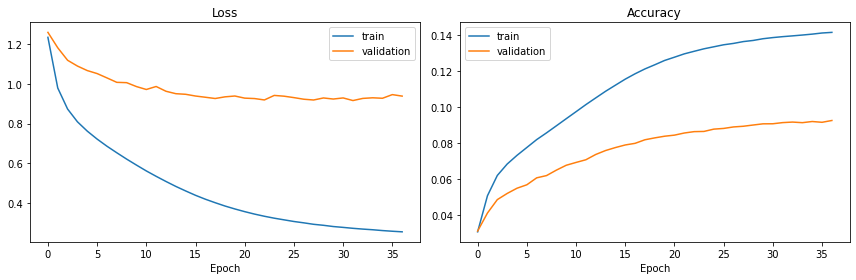

2025-04-21 04:56:39,770 - __main__ - INFO - 모델이 ./checkpoints/transformer/final_model에 저장되었습니다.


In [45]:
EPOCHS = 50

try:
    history = model.fit(
        train_dataset,
        epochs=EPOCHS,
        validation_data=val_dataset,
        callbacks=[early_stopping, cp_callback],
        verbose=1
    )
    # 학습 로그 저장
    with open(history_path, 'w', encoding='utf-8') as f:
        json.dump(history.history, f, ensure_ascii=False, indent=2)
    logger.info(f"학습 로그 저장 완료: {history_path}")

    # 학습 결과 시각화
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='validation')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 최종 모델 저장
    final_model_path = os.path.join(checkpoint_dir, "final_model")
    model.save_weights(final_model_path)
    logger.info(f"모델이 {final_model_path}에 저장되었습니다.")

except Exception as e:
    logger.error(f"학습 중 오류 발생: {e}")
    # 오류 발생 시 더 작은 모델로 재시도
    SIMPLE_NUM_LAYERS = 2
    SIMPLE_D_MODEL = 256
    SIMPLE_UNITS = 512
    simple_model = improved_transformer(
        vocab_size=VOCAB_SIZE,
        num_layers=SIMPLE_NUM_LAYERS,
        units=SIMPLE_UNITS,
        d_model=SIMPLE_D_MODEL,
        num_heads=NUM_HEADS,
        dropout=DROPOUT
    )
    simple_model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss=weighted_loss_function,
        metrics=[accuracy]
    )
    simple_history = simple_model.fit(
        train_dataset,
        epochs=10,
        validation_data=val_dataset,
        callbacks=[early_stopping, cp_callback],
        verbose=1
    )
    simple_model.save_weights(os.path.join(checkpoint_dir, "simple_final_model"))

## Step 5. 추론 및 대화 인터페이스 개선

### 5-1 대화 맥락 기반 챗봇 추론 클래스

In [46]:
import tensorflow as tf
import numpy as np
import os
import json
import datetime

class KoreanChatbotSession:
    """
    대화 맥락을 유지하며, 언제든지 새로 시작할 수 있는 한국어 챗봇 세션 클래스
    """
    def __init__(self, model, tokenizer, max_length=50, context_turns=3):
        self.model = model
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.start_token = tokenizer.vocab_size
        self.end_token = tokenizer.vocab_size + 1
        self.context_turns = context_turns
        self.reset_context()
        self.session_id = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')

    def reset_context(self):
        self.context = []

    def add_to_context(self, user, text):
        self.context.append({'user': user, 'text': text})
        # 최근 n턴만 유지
        if len(self.context) > self.context_turns * 2:
            self.context = self.context[-self.context_turns*2:]

    def build_context_input(self, user_input):
        # 최근 대화 맥락을 이어 붙여 입력으로 사용
        context_text = ""
        for turn in self.context[-self.context_turns*2:]:
            prefix = "사용자: " if turn['user'] == 'user' else "챗봇: "
            context_text += f"{prefix}{turn['text']}\n"
        context_text += f"사용자: {user_input}\n챗봇: "
        return context_text.strip()

    def preprocess_input(self, text):
        tokens = self.tokenizer.encode(text)
        tokens = [self.start_token] + tokens + [self.end_token]
        tokens = tokens[:self.max_length] + [0] * (self.max_length - len(tokens[:self.max_length]))
        return tf.expand_dims(tokens, 0)

    def generate_response(self, user_input, temperature=0.7, max_length=50):
        """맥락을 반영한 응답 생성"""
        context_input = self.build_context_input(user_input)
        encoder_input = self.preprocess_input(context_input)
        decoder_input = tf.expand_dims([self.start_token], 0)
        for _ in range(max_length):
            predictions = self.model([encoder_input, decoder_input], training=False)
            predictions = predictions[:, -1, :]
            predictions = predictions / temperature
            predicted_id = tf.random.categorical(predictions, num_samples=1)[0, 0].numpy()
            if predicted_id == self.end_token:
                break
            decoder_input = tf.concat([decoder_input, tf.expand_dims([predicted_id], 0)], axis=-1)
        output_tokens = [int(i) for i in decoder_input[0].numpy()]
        if output_tokens[0] == self.start_token:
            output_tokens = output_tokens[1:]
        if self.end_token in output_tokens:
            end_idx = output_tokens.index(self.end_token)
            output_tokens = output_tokens[:end_idx]
        output_text = self.tokenizer.decode(output_tokens)
        # 맥락에 추가
        self.add_to_context('user', user_input)
        self.add_to_context('bot', output_text)
        return output_text

    def save_session(self, save_dir='chatbot_sessions'):
        os.makedirs(save_dir, exist_ok=True)
        session_path = os.path.join(save_dir, f'session_{self.session_id}.json')
        with open(session_path, 'w', encoding='utf-8') as f:
            json.dump(self.context, f, ensure_ascii=False, indent=2)
        return session_path

### 5-2 CLI 기반 대화 인터페이스

In [47]:
def run_chatbot_cli(model, tokenizer):
    print("한국어 챗봇에 오신 것을 환영합니다! 언제든 '새로시작', '종료', 'quit', 'exit'을 입력해 대화를 제어할 수 있습니다.\n")
    session = KoreanChatbotSession(model, tokenizer)
    while True:
        user_input = input("사용자: ").strip()
        if user_input.lower() in ['종료', 'quit', 'exit']:
            print("챗봇 세션을 종료합니다. 대화 기록을 저장합니다.")
            path = session.save_session()
            print(f"대화 기록이 {path}에 저장되었습니다.")
            break
        elif user_input.lower() in ['새로시작', 'reset', 'restart']:
            print("대화 맥락이 초기화되었습니다. 새로운 대화를 시작하세요.")
            session.reset_context()
            continue
        elif user_input == "":
            continue
        else:
            response = session.generate_response(user_input)
            print(f"챗봇: {response}")

# 사용 예시
# run_chatbot_cli(model, tokenizer)

In [48]:
run_chatbot_cli(model, tokenizer)

한국어 챗봇에 오신 것을 환영합니다! 언제든 '새로시작', '종료', 'quit', 'exit'을 입력해 대화를 제어할 수 있습니다.

사용자: 안녕! 점심 맛있게 먹었니?
챗봇: 마음 의 병 이 조금 씩 나아지 길 바랍니다 .
사용자: 나 마음이 병 없어. 행복해!
챗봇: 2 2
사용자: 이전 모델보다 나을 줄 알았는데, 바보같이 답장하네
챗봇: 3 만 여 권
사용자: 1+1은?
챗봇: 10 위
사용자: 1+1=10이라고?
챗봇: 중독 에서 벗어나 세요 .
사용자: 중독? 무슨 중독?
챗봇: 허준영
사용자: 허준영은 누구야 또...
챗봇: 학생 군사 교육 단
사용자: 군인이야?
챗봇: 코 가 간질간질 한가 봐요 .
사용자: 참나
챗봇: 모 쏠 여부 가 큰 걸림돌 이 되 지 않 을 거 예요 .
사용자: ㅋㅋㅋㅋㅋㅋㅋ모쏠 여부라니... 그리고 나 연애 중이야
챗봇: 550 만
사용자: 됐다 그만하자
챗봇: 10 위
사용자: 종료
챗봇 세션을 종료합니다. 대화 기록을 저장합니다.
대화 기록이 chatbot_sessions/session_20250421_050301.json에 저장되었습니다.


In [49]:
run_chatbot_cli(model, tokenizer)

한국어 챗봇에 오신 것을 환영합니다! 언제든 '새로시작', '종료', 'quit', 'exit'을 입력해 대화를 제어할 수 있습니다.

사용자: 안녕! 다시한번 대화를 시도하려고 왔어.
챗봇: 다치 지 않 으셨 나 걱정 이 네요 .
사용자: 마음이 좀 다친 것 같아. 너때문에.
챗봇: 주물주물 해 주 세요 .
사용자: ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ
챗봇: 2 2
사용자: 너가 제일 좋아하는 단어는 뭐야?
챗봇: 약 1 cm
사용자: ?
챗봇: 학생 군사 교육 단
사용자: 난 금요일에 만들었던 모델을 사용할게. 너는 너무 성능이 낮아.
챗봇: 라디오 를 들으며 여유 를 가져 보 세요 .
사용자: 그런다고 해결되는게 아니야.
챗봇: 2 2
사용자: 안녕!
챗봇: 5 개
사용자: 종료.
챗봇: 깨질지 모르 겠 어요 .
사용자: 아
챗봇: 1603 년
사용자: 종료
챗봇 세션을 종료합니다. 대화 기록을 저장합니다.
대화 기록이 chatbot_sessions/session_20250421_050550.json에 저장되었습니다.


## 학습 로그(수치) 분석

### loss/val_loss
에폭이 진행될수록 꾸준히 감소하고, val_loss도 점진적으로 개선됨

### accuracy/val_accuracy
0.03(3%)에서 시작해 0.09(9%)까지 서서히 증가

### early stopping 없이 30에폭 이상 학습 진행

### 과적합 징후 없음

### → 표면적으로는 학습이 잘 되고 있다는 신호처럼 보임

## 실제 대화 응답

### 답변 퀄리티
맥락, 상식, 감정, 자연스러움 모두에서 매우 낮은 품질을 보임

### 문제점
의미 없는 숫자, 단어, 맥락 무관 답변, 상식적 오류(1+1=10 위 등) 다수